# Import Standard Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Advanced Lane Finder Modules

In [4]:
import alf_cam
import alf_enh
import alf_war
import alf_llg
import alf_hud
import alf_con
import alf_utils

alf_utils.init_logging()

INFO     | alf_utils: Logging initialized.


In [ ]:
# main controller
ctrlr = alf_con.Controller()

# Project Video Processing

In [ ]:
project_video__OLD__ = {
    'filename'   : 'project_video.mp4',
    'sob_min_x'  : 5,
    'y_min_s'    : 57,  
    'y_min_v'    : 220,
    'w_max_s'    : 25,
    'w_min_v'    : 201,
    'max_coeffs' : 50,
    'min_samples': 3,
    'N'          : 12,
    'coeff_bias' : 0.9,
    'clip_start' : None,
    'clip_end'   : None,
    'stage'      : 1,
    'output'     : 'project_video.mp4'
}

project_video = {
    'filename'   : 'project_video.mp4',
    # 0 for max sensitivity to gradients
    'sob_min_x'  : 5,
    # yellow
    'y_min_s'    : 76,    
    'y_min_v'    : 96,
    # white
    'w_max_s'    : 30,
    'w_min_v'    : 202,   
    # smoothing
    'max_coeffs' : 50,
    'min_samples': 3,
    'N'          : 12,
    'coeff_bias' : 0.9,
    'clip_start' : None,
    'clip_end'   : None,
    'stage'      : 5,
    'output'     : 'project_video.mp4'
}


ctrlr = alf_con.Controller()
ctrlr.processVideo(project_video)

In [ ]:
challenge_video = {
    'filename'   : 'challenge_video.mp4',
    'sob_min_x'  : 10, 
    'y_min_s'    : 25,  
    'y_min_v'    : 150,
    'w_max_s'    : 12, 
    'w_min_v'    : 158,
    'max_coeffs' : 15,
    'min_samples': 3,
    'N'          : 3,
    'coeff_bias' : 0.9,
    'clip_start' : None,
    'clip_end'   : None,
    'stage'      : 5,
    'output'     : 'challenge_video.mp4'
}

ctrlr = alf_con.Controller()
ctrlr.processVideo(challenge_video)

In [ ]:
harder_challenge_video = {
    'filename'   : 'harder_challenge_video.mp4',
    'sob_min_x'  : 10, # tried: 5
    'y_min_s'    : 128, # tried: 87
    'y_min_v'    : 230, 
    'w_max_s'    : 15, # tried: 12, 25 
    'w_min_v'    : 200, # tried: 158, 125
    'max_coeffs' : 60,
    'min_samples': 3,
    'N'          : 12,
    'coeff_bias' : 0.9,
    'clip_start' : None,
    'clip_end'   : None,
    'stage'      : 5,
    'output'     : 'harder_challenge_video.mp4'
}  
ctrlr = alf_con.Controller()
ctrlr.processVideo(harder_challenge_video)

In [ ]:
alf_utils.demoChessboardCorners()

In [ ]:
alf_utils.demoCameraCalibration()

In [ ]:
alf_utils.createUndistStraight()

INFO     | Camera: Calibrating...
INFO     | ChessboardImages: Loading chessboard images...
INFO     | ChessboardImages: ...completed loading chessboard images.
INFO     | ChessboardImages: Finding chessboard corners...
INFO     | ChessboardImages: ...completed finding chessboard corners.
INFO     | Camera: ...calibrated.
INFO     | ImageWarper: Transformation matrices created.


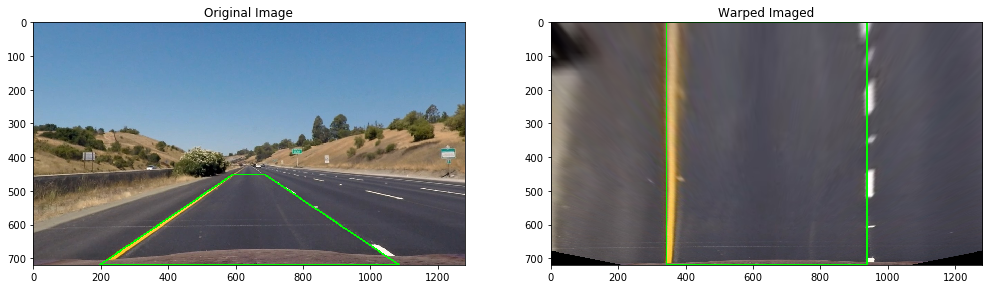

In [7]:
img = plt.imread("test_images/straight_lines1.jpg")
alf_utils.demoWarpImage(img)

In [ ]:
img = plt.imread("test_images/test5.jpg")
alf_utils.demoEnhance(img)

In [ ]:
img = plt.imread("test_images/test5.jpg")
alf_utils.demoLaneSearch(img)

In [ ]:
img = plt.imread("test_images/test5.jpg")
alf_utils.demoCompose(img)

In [ ]:
alf_utils.shutdown_logging()

In [ ]:
import alf_cam



cam = alf_cam.Camera()
cam.calibrate()
cam.

In [ ]:
%autoreload 2

import alf_cam
init_logging()
cam  = alf_cam.Camera()
cam.calibrateCamera()


In [ ]:
%autoreload
import alf_enh
import alf_war
import alf_llg
import alf_hud


# Writeup.md

7-JAN-2021
# Advanced Computer Lane Finding 
Implement a video processing pipeline that detects road lanes.


## Goals
- Correct image distortion by computing the camera matrix and distortion coefficients.
- Enhance lane pixels by applying  color transforms and gradients. 
- Apply a perspective transform to rectify image to a top-down view of road.
- Identify lane pixels and fit into a 2-degree polynomial to represent a lane.
- Calculate a radius of curvature and position of vehicle with respect to center.
- Compose an image that clearly identifies the lane area.
- Fulfill a requirement of the Udacity Self-Driving Car Engineer Nanodegree Program.
- Practice using the following: opencv, classes, modules, UML sketching, GRASP, and docstring.

## Distortion correction
Ensuring that straight lines in the real world appear straight in image space prevents false curves from being processed by later stages of the pipeline.

### Chessboard Corners

The opencv function `findChessboardCorners()` was used to calculate object points and image points representing the inner corners of multiple chessboard images:


```
###
### Code location: alf_cam.py
###

class ChessboardImage:

    ...
    
    def findChessboardCorners(self):

        ...
        
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        corners_found, corners = cv2.findChessboardCorners(gray, (self.xdim, self.ydim), flags=None)
        
        if corners_found:
        
            ...
            
            self.objpoints = np.zeros(shape=(self.xdim * self.ydim, 3), dtype=np.float32)
            self.objpoints[:, :2] = np.array([(x, y) for y in range(self.ydim) for x in range(self.xdim)])
	        self.imgpoints = corners
            
            ...
            
        return corners_found
```

Image below verifies the chessboard corners found:
![Chessboard corners found](output_images/wup_corners_calibration13.png)

### Camera Calibration

The objpoints and imgpoints data were used to compute the camera matrix and distortion coefficients. Calibration is performed using the opencv function `calibrateCamera()`, then `undistort()` is called in the main pipeline which performs the actual distortion correction:

```
###
### Code location: alf_cam.py
###

class Camera:

    ...
    
    def calibrate(self, calibration_set=None):

        ...
    
        if calibration_set is None:
            calibration_set = ChessboardCameraCalibrationSet()
            
        objpoints, imgpoints, self.image_shape = calibration_set.getCalibrationParams ()
        
        #--- rotation and translation vectors not used for this project
        cal_found, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_shape, None, None)
        
        ...
        
        return
        
        ...	
        
    def undistort(self, img):
        img_undist = cv2.undistort(img, self.mtx, self.dist)
        return img_undist	
```

Image below verifies camera calibration. The apparent curve of straight lines due to lens distortion is corrected to appear straight in the output image:

![](output_images/wup_camera_calibrate.png)

## Image Enhancement
Edge detection and color transformation is applied to the image corrected for distortion. Combining Sobel X-gradient and color space masks help pickout yellow and white lanes. 

### Sobel X-Gradient Masking

The Sobel function helped with detecting lanes in low contrast areas where the lightness of the road was similar to the lightness of the lanes.  

```
###
### Code location: alf_enh.py
###

class Enhancer:

    ...
    
    def sobelXMask(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
       
        mask = np.zeros_like(sobel_scaled)
       
        # activate (set to "1") all pixels that meet the x gradient thresholds
        mask[(self.sob_min_x <= sobel_scaled) & (sobel_scaled <= 255)] = 1
       
        return mask
```

### HSV Color Masking

The color transforms were done in the HSV colorspace because the image editing tools used to idenfity the color values worked in the HSV space. Yellow and white lane masks are combined with a bitwise OR:

```
###
### Code location: alf_enh.py
###

class Enhancer:

    ...

    def laneMask(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        h = hsv[:,:,0] # h-channel
        s = hsv[:,:,1] # s-channel
        v = hsv[:,:,2] # v-channel

        # mask for yellow lane
        y_mask = np.zeros_like(s)
        y_h = (10 <= h) & (h <= 25)
        y_s = s > self.y_min_s
        y_v = v > self.y_min_v
        y_mask [(y_h & y_s & y_v)] = 1

        # mask for white lane
        w_mask = np.zeros_like(s)
        w_s = s < self.w_max_s
        w_v = self.w_min_v < v
        w_mask[(w_s & w_v)] = 1

        return y_mask | w_mask
```

### Combining Masks

The sobel x-gradient mask is combined with the lane mask with bitwise AND: 

```
### 
### Code location: alf_enh.py:
###

class Enhancer:
    ...
    def enhance(self, img):
        sobel_mask = self.sobelXMask (img)
        lane_mask = self.laneMask(img)       
        return sobel_mask & lane_mask
```

If edge detection was not performed, the image would look like random noise in those low contrast, similarly colored areas. If the sobel mask was combined using a bitwise OR, we would get additional noise that would make it difficult for the later stages to pickout the lane. Keeping a low edge detection threshold helped pick out the lanes where the values and saturation of the white lanes were similar with light colored concrete:

![](output_images/wup_enhancer.jpg)

## Top-down View
The perspective of the road area is transformed to a top-down view prior to lane pixel search and detection. To select the region, an undistorted image of a straight section of road is taken, and a line was drawn with an image editor to coincide with one of the straight lanes. The other line is derived from taking the inverse slope of the first and the four points of the trapezoid are then read from the image editor. In the actual pipeline, the trapezoidal region is transformed after the edge detection and color transformation masks are applied. A rectangular region is then plotted to which the trapezoid is transformed:

![](output_images/wup_topdown.png)

The trapezoidal region of the source image and the rectangular region of the destination is used to compute the perspective transformation matrix, `M`, to achieve a top down view using opencv's `warpPerspective()`. Its inverse, `invM`, is used to transform the top down view back into the original perspective on the road image using `unwarpPerspective()` in the final stage of the pipeline:

```
###
### Code location: alf_enh.py
### 

class Warper:
    ...
    def calibrate(self):
        # M: transformation matrix
        self.M = cv2.getPerspectiveTransform(self.calibration_set.src_points, 
                                            self.calibration_set.dst_points)
        # use invM when unwarping image
        self.invM = cv2.getPerspectiveTransform(self.calibration_set.dst_points, 
                                                self.calibration_set.src_points)
        return

    def warpPerspective(self, img):
        img_warped = cv2.warpPerspective(img, self.M, 
              (img.shape[1], img.shape[0]), 
              flags=cv2.INTER_LINEAR)
        return img_warped
    
    def warpPerspective(self, img):
        img_unwarped = cv2.warpPerspective(img, self.invM, 
             (img.shape[1], img.shape[0]), 
             flags=cv2.INTER_LINEAR)
        return img_unwarped
```

## Lane Pixel Identification and Line Fitting

A "sliding window" search area and, when a line was successfully found in a previous frame, a "linear window" was used to gather pixels associated with a lane. It used the top down binary image from the warp (perspective transformation) stage to identify lane pixels.

### Sliding Window Search Area

The "sliding window" search area defined a rectangle, `(x1, y1, x2, y2)`, which starts at the base of the image and progressively "slides" up the image to gather lane pixels within the boundaries of the rectangle. The lane pixels are gathers in separate x and y position arrays `lane_points_x` and `lane_points_`. The horizontal (x) position of the rectangle is adjusted to the average x position of all pixels found if a threshold number of points was reached. Also, if not enough pixels were found the window is slid in the last direction of found pixels so that it just does not slide upwards. Rather, it slides in the direction the previous window slid. The sliding stops once it reaches the top (when y1 == 0). 

```
###
### Code location: alf_llg.py
###

class SlidingWindow:

    ...
    
    def findPoints(self):
   
        while not self.passed_top:        
           
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
           
            # mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            # bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            # apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            # collect the points found into lane_points_x and _y
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            # update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                new_x_mid = np.int(np.average(points_found_x))
                self.x_dir = new_x_mid - self.x_mid
                self.x_mid = new_x_mid
            elif (len(points_found_x) < self.numpoints_found_thresh // 3 and self.x_dir is not None):
                self.x_mid += self.x_dir

            self.slideUp()
       
        return (self.lane_points_x, self.lane_points_y)
```

### Line Fitting

The lane points in separate x and y arrays are then used to find a line that best represents the lane using numpy's `polyfit()`:

```
###
### Code location: alf_llg.py
###

class Line:

    ...
    
    def fit(self, x_points, y_points):
        self.pts = None    
        self.x = None
        self.y = None 
        self.found = False 
        tries = 0
        max_tries = 3
        while tries < max_tries and not self.found:
            tries += 1
            try:
                # remember we solve for X!!! i.e. x = ay^2 + by + c
                coeffs = np.polyfit(y_points, x_points, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.debug(msg.format(tries))
                self.found = True
            
            except Exception as e:
                if tries < max_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.debug(msg.format(e))
                else:
                    msg = "Polyfit failed to fit a line. {}."
                    self.logger.debug(msg.format(e))
                    
        if self.found:
            self.coeffs = coeffs
        else:
            self.coeffs = None
            
        return
```

### Smoothing

Once a fit has been determined, the line goes through a smoothing process which adjusts the coefficients to a weighted average of previous coefficients. If the fit is not within a specified `N` standard deviations of the average of previous coeffs, the most recent set of coefficients is used for the current line:

```
###
### Code location: alf_llg.py
###

class Line:

    ...
    
    def smooth (self):
        
        good_fit = False
        
        if self.prev_coeffs:
            
            avg_prev_coeffs = np.average(self.prev_coeffs, axis=0)
            
            if self.found:
                
                if len (self.prev_coeffs) > self.min_samples:
                    # see if coeff of line is within std devs of avg 
                    # of previous lines 
                    std_prev_coeffs = np.std(self.prev_coeffs, axis=0)
                    in_range = (abs(self.coeffs - avg_prev_coeffs) 
                               < self.N*std_prev_coeffs)
                else:
                    in_range = [True]
                    
                good_fit = all (in_range)

                if good_fit:
                    self.logger.debug("Line fit seems ok.")
                    # coeffs use avg prev coeffs based on bias
                    # set coeff bias to 1 to prevent bias from prev coeffs
                    self.coeffs = (self.coeff_bias*self.coeffs
                                  + (1-self.coeff_bias)*avg_prev_coeffs)
                    self.prev_coeffs.append(self.coeffs) 
                    if len(self.prev_coeffs) > self.max_coeffs:
                        # pop first to remove oldest line from list to 
                        # prevent being include in average
                        self.prev_coeffs.pop(0)
                        msg = "Coeff buffer full:{}. Removed oldest line."
                        self.logger.debug(msg.format(len(self.prev_coeffs)))
                
                else:
                    self.logger.debug("Line fit looks off; "
                        + "will use average of previous.")
                    self.coeffs = avg_prev_coeffs
                    # set found to False since line fit was bad
                    # remove oldest line; allows list of previous fits
                    # to decay to nothing if consecutive bad lines are
                    # are found
                    self.prev_coeffs.pop(0)
                    
            else:
                # line not found, use average of previous coffecients 
                self.logger.debug("Line was not found! "
                    + "Using average of old lines.")
                self.coeffs = avg_prev_coeffs                
                self.prev_coeffs.pop(0)
                # set found to True since we "found" a line 
                # using the average of previous coeffs
                
        elif self.found:
            # first coeff to add to list! 
            good_fit = True
            # don't smooth since there is nothing to smooth to
            self.prev_coeffs.append(self.coeffs) 
            
        msg = "Number of old lines/coeffs: {}."
        self.logger.debug(msg.format(len(self.prev_coeffs)))
            
        return good_fit
```

### Sliding Window Search Area Detections

The coefficients of the line can then be used to represent the real world lane. Below is an example of the sliding windows (green), detected pixels (yellow and blue), and lane lines (red):

![](output_images/wup_sliding_window.png)

### Linear Window Search Area

If a line has been found in a previous frame, a linear window search area is used. The borders of the search area are simply  offsets to either side of the line, `(LinearWindow.x1, LinearWindow.x2)`. Pixels are simply gathered for those that are within these linear borders:

```
### 
### Code location: alf_llg
###

class LinearWindow:
    
    def findPoints (self):
        
        # mask in all points within linear window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        # apply mask to image_points_x and _y to find the points 
        # that are in linear window search area 
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        # collect the points found into lane_points_x and _y
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        # the x coordinates of the line may be modified after line smoothing
        # and may not reflect the original search area
        # so save the x coordinates after find findpoints for use in paint
        self.x_search_line = [self.line.lookupX(y) for y in range(self.ht)]
        
        return self.lane_points_x, self.lane_points_y    
```

### Linear Window Search Area Detections

Below is an example of the linear windows search areas, the borders on each side, lane pixels detected within those borders, and the lines representing the lanes:

![](output_images/wup_linear_window.png)

### Lane Area

With both lane lines detected, a polygon is formed which is filled to highlight the lane area:

![](output_images/wup_lane_area.png)

## Radius of Curvature and Center Offset

To calculate the radius of curvature, the suggestion in *Lesson 8 - Measuring Curvature II* is used which allows us to skip doing another line fit since we are scaling the image space to real world space. The challenge is to derive the real world line coefficients from the existing coefficients in the pixel space (scale to meters from pixels).

### Scaling Line Coefficients to Real World

The goal is to find a_mtr, b_mtr, c_mtr in terms of corresponding values in pixel space and scaling factors, mx, my.

Given:
```
y_mtr = my * y_pix  so: y_pix = y_mtr/my
x_mtr = mx * x_pix  so: x_pix = x_mtr/mx
```

The line in the by the second degree polynomial in real world:
```
x_mtr = a_mtr*(y_mtr)**2 + b_mtr*y_mtr + c_mtr
```

Similarly, in pixel space:
```
x_pix = a_pix*(y_pix)**2 + b_pix*y_pix + c_pix
```

Substitute x_pix and y_pix:
```
x_mtr/mx = a_pix*(y_mtr/my)**2 + b_pix*(y_mtr/my) + c_pix
```

Arrange the y-scale factor, `my`:
```
x_mtr/mx = (a_pix/my**2)*(y_mtr)**2 + (b_pix/my)*(y_mtr) + c_pix
```

Multiply both sides by mx to solve for x_mtr:
```
x_mtr = mx*((a_pix/my**2)*(y_mtr)**2 + mx*(b_pix/my)*(y_mtr) + mx*c_pix
```

Arrange the x-scale factor, `mx`:
```
x_mtr = (a_pix*mx/my**2)*(y_mtr)**2 + (b_pix*mx/my)*(y_mtr) + mx*c_pix
```

But since: 
```
x_mtr = a_mtr*(y_mtr)**2 + b_mtr*y_mtr + c_mtr
```

The coefficients in real_world (a_mtr, b_mtr, c_mtr) can be scaled in terms of their corresponding pixel coefficients using the following:
```
a_mtr = a_pix*mx/(my**2)
b_mtr = b_pix*mx/my
c_mtr = c_pix*mx
```

So scaling the pixel coefficients to real world coefficients can now be implemented, whilst skipping another call to polyfit using points scaled to real world (note we use the scaling factors, XM_PER_PIXEL and YM_PER_PIXEL) presented in the lesson:

```
###
### Code location: alf_llg.py
###

# image to real space scaling default per lesson Measuring Curvature II
# in meters per pixel; used in calculating radius of curvature
# as well as offset center
XM_PER_PIXEL = 3.7 / 700    
YM_PER_PIXEL = 30 / 720


class Line:

    ...

    def radius(self, y, xm_per_pix=None, ym_per_pix=None):
        if not self.found:
            return None
        try:
            # rescale coeffs and y to real world
            a = self.coeffs[0] * xm_per_pix / ym_per_pix**2
            b = self.coeffs[1] * xm_per_pix / ym_per_pix
            y = y * ym_per_pix    # scale y to real-world!
            R = (1 + (2*a*y + b)**2)**(3/2) / abs(2*a)
            msg = "Radius of curvature: {}."
            self.logger.debug(msg.format(R))
        except Exception as e:
            msg = "Error in calculating radius of curvature: {}."
            self.logger.warning(msg.format(e))
            R = None
        return R
```

### Center Offset

The x-coordinate of each line at the base of the image, `Line.baseX()`, is used to calculate the center x-coordinate between the two lanes, `lane_ceter`. It is then subtracted by the center coordinate of the screen, `img_ctr`, to calculate the offset of the vehicle from center line.

```
###
### Code location: alf_llg.py
###
class Line

    ...

    def baseX(self):
        '''
        Returns the x coordinate of the "base" of the line; i.e. at the bottom of image.
        
        Notes:
        - Used in calculating offset from center for the lane finder
        - Call generateXY() before calling this
        - returns none if no line was found
        '''
        
        if not self.found:
            return None
            
        return self.x[-1]


class AdvancedLaneFinder:

    def centerOffset(self):
        
        img_ctr = self.binary_warped.shape[1] // 2
        
        t = 0    # sums up x values
        n = 0    # count of number of samples

        # get distance from center
        x_left =  self.left_lane_line_finder.baseX()
        t  += x_left if x_left is not None else 0
        n  += 1 if x_left is not None else 0
        
        x_right = self.right_lane_line_finder.baseX()
        t  += x_right if x_right is not None else 0
        n  += 1 if x_right is not None else 0
        
        if n > 0:
            lane_center = t / n
            self.center_offset = (lane_center - img_ctr) * XM_PER_PIXEL
        else:
            self.center_offset = None
            
        msg = "Center offset: {}."
        self.logger.debug(msg.format(self.center_offset))
            
        return self.center_offset 

```

## Final image composition

Because the lane area is in the top down perspective, the main controller reuses the warper component to unwarped the lane area, then uses HUD (for Heads Up Display) component to blend the lane area with the original *undistorted* image, and write the radius of curvature and center offset.

```

###
### Code location: alf_con.py 
###

class Controller:

    ...
    
    def processImg(self, img):
    
        ...
        
        unwarped_lanes      = self.war.unwarpPerspective(lane_area)
        final_img           = self.hud.compose(img_undistorted, unwarped_lanes, rad, off)
        
        ...
```

```
###
### Code location: alf_war.py
###

class Warper:

    ...

    def unwarpPerspective(self, img):
        
        img_unwarped = cv2.warpPerspective(img, self.invM, 
                (img.shape[1], img.shape[0]), 
                flags=cv2.INTER_LINEAR)
        
        return img_unwarped
```

```
###
### Code location: alf_hud.py
###

class HUD:

    ...
    
    def blendImages(self, img_undistorted, unwarped_lanes):
        
        self.img_lane_area = cv2.addWeighted(img_undistorted, 
                                             alpha = 1.0, 
                                             src2  = unwarped_lanes, 
                                             beta  = 0.3, 
                                             gamma = 0.0)
        
        return
    
    def putRadius(self, rad):
    
        radius = rad
        if radius is None:
            rad_str = "Radius:"
        elif radius >= 2000: 
            # we'll use around 2km for a road that feels straight
            # min curve radius with superelevation 80mph 4575ft ~1.4km
            # per U.S. government specifications for highway curvature: 
            # link: https://tinyurl.com/y42ulukp
            rad_str = "On straightaway"
        else:
            msg = "Radius: {:.2f} km"
            rad_str = msg.format (radius / 1000)
        
        cv2.putText(self.img_lane_area, rad_str, (50, 50), self.font, self.scale, self.color, self.thickness)
        
        return
        
    def putCenterOffset(self, off):
        
        center_offset = off
        if center_offset is None:
            off_str = "Center offset "
        else:
            if abs (center_offset) < 0.1:  #--- 0.1 m or 10 cm
                #--- if it's within 10cm it's on centerline...comeon!!!!
                off_str = "Roughly on centerline!"
            else:
                if center_offset > 0:
                    msg = "Center Offset: {:.0f} cm Left"
                else:
                    msg = "Center Offset: {:.0f} cm Right"
                off_str = msg.format (abs(center_offset * 100))
        
        cv2.putText(self.img_lane_area, off_str, (50, 100), self.font, self.scale, self.color, self.thickness)
        
        return
    
    def compose(self, img_undistorted, unwarped_lanes, rad, off):
        
        self.blendImages(img_undistorted, unwarped_lanes)
        
        self.putRadius(rad)
        self.putCenterOffset(off)
        
        return self.img_lane_area
```

The lane area, radius of curvature, center offset, and the original image are combined to compose the final image. 

![](output_images/wup_compose.png)

## The Pipeline Overview
The pipeline processes each frame of the road video as an individual image by performing the following functions mentioned in the previous sections:
- Distortion correction that reduces apparent curvature of straight lines
- Image enhancement that detects edges detection and transforms color values
- Image transformation that results in a top down view of road
- Lane area identification that identifies pixels belonging road lanes
- Another image transformation that restores the top-down view of the lane area to the original perspective
- Composing the original undistorted image with lane area, radius of curvature, and center offset

It uses a `controller` to coordinate and sequence the various components of the pipeline:

```
###
### Code location: alf_con.py 
###

class Controller:

    ...
    
    def processImg(self, img):
    
        ...
        
        srch_only           = (self.stage == 3)
        img_undistorted     = self.cam.undistort(img)
        binary              = self.enh.enhance(img_undistorted)    
        binary_warped       = self.war.warpPerspective(binary)
        lane_area, rad, off = self.alf.paintLaneArea(binary_warped, srch_only)
        unwarped_lanes      = self.war.unwarpPerspective(lane_area)
        final_img           = self.hud.compose(img_undistorted, unwarped_lanes, rad, off)
        
        ...
        
```

### Project Video

The pipeline appears to have succesfully identified the lane area and is located in the `output_images` folder with filename `project_video.mp4`: [output_images/project_video.mp4](./output_images/project_video.mp4)

![](output_images/wup_project_video.png)

### Pipeline Struggles, but Completes Challenge Video...
The pipeline also appears to have succesfully worked on the challenge video. The output is located here: [output_images/challenge_video.mp4](output_project/challenge_video.mp4)

![](output_images/wup_challenge_video.png)

### ...and Fails Miserably on Harder Challenge Video
The tight curves, brush and trees on either side of the road, dashboard glare, varied lighting conditions, and traffic were some of the challenges that prevented the pipeline from consistently detecting the lanes in this video:  [output_images/challenge_video.mp4](output_project/challenge_video.mp4)

![](output_images/wup_harder_challenge_video.png)

## Limitations, Issues, Challenges
- Varied lighting conditions made it a challenge to find good HSV values that would help the pipeline detect lanes in all frames.
- Dashboard glare detrimentally affects performance.
- Camera lens aperture changes detrimentally affects performance (aperture appears to change from shadow area to light area).
- There is no universal set of pipeline parameters. The pipeline parameters are tuned to a specific video. So the pipeline parameters for one video may not work on another.
- Pipeline will fail on sudden, tight curves. 
- It will struggle on extended light colored roads; dried brush on side of road will fool pipeline into thinking it is a lane; guardrail on side of road looks like white lane.
- Bumpy roads (such as going over a brdige) will change the perspective of the road and may make the lanes either coverge or diverge.

## Areas of Improvement
- Investigate use of CNN/YOLO to identify lane and edges of lane (and traffic!).
- Identify center of road instead of lane markers.
- Dynamically adjust pipeline parameters. Perhaps take the histogram of the bottom half of frame and stretch the HSV values to achieve better color, light and shadow separation.
- Use some kind of A* search for lane pixels where search area is biased in direction of where more pixels are located.
- Sensor-related: Use of a polarizing filter on camera to help with glare. Use constant aperture (don't go full auto on camera); mount camera on front of car sensor improvements; use lens hood; use some kind of 3-axis stabilization for sensor
- Creating a virtual test track (ex: on Unreal Studio) will allow experimenting with perfect conditions to progressively worse conditions and may be a cost effective approach in further researching lane detecting algorithms.

# Old Stuff
---

In [ ]:
def stretch(c):
    avg = np.average(c)
    lo = c.min()
    hi = c.max()

    below = c[c < avg]
    below = 128 - 128 * (avg - below)/(avg - lo)
    c[c < avg] = np.clip(below, 0, 255)

    above = c[c >= avg]
    above = 128 + 128 * (above - avg)/(hi - avg)
    c[c >= avg] = np.clip(above, 0, 255)
    
    return



img = plt.imread("output_images/test.jpg")


hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

h = hsv[:,:,0] # h-channel
s = hsv[:,:,1] # s-channel
v = hsv[:,:,2] # v-channel

avg = np.average(s)
print(avg)

lo = s.min()
hi = s.max()
avg, lo, hi


'''
if p < avg:
    m = (avg - p) / (avg - lo)
    o = 128 - 128 * m
else:
    # p > avg:
    m = (p - avg) / (hi - avg)
    o = 128 + 128 * m

'''
    
stretch(s)
stretch(v)

rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
plt.figure(figsize=(14, 6))
plt.subplot(121).imshow(img)
plt.subplot(122).imshow(rgb)


In [ ]:
x = 686
y = 451
m = 0.67191601049869
b = y - m*x
b

In [ ]:
y = 719
x = (y - b) / m
x

In [ ]:
m = -0.67191601049869
b = 848.47769028871
y = 719
x = (y - b) / m
x

In [ ]:

init_logging()
enh  = alf_enh.Enhancer()
imw  = alf_war.ImageWarper()
alf  = alf_llg.AdvancedLaneFinder()
hud  = alf_hud.HUD(alf, imw)

#-------------------------------------------------

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
 
def test_enh(img):
    img_undistorted = cam.undistort(img)
    binary          = enh.enhance(img_undistorted)    
    
    return binary
    
def test_war(img):

    img_undistorted = cam.undistort(img)
    binary          = enh.enhance(img_undistorted)    
    binary_warped   = imw.warpPerspective(binary)
    
    return binary_warped

def test_all(img):
    img_undistorted = cam.undistort(img)
    binary          = enh.enhance(img_undistorted)    
    binary_warped   = imw.warpPerspective(binary)
    alf.findLanes(binary_warped)  #--- TODO: change this
    final_img       = hud.compose(img_undistorted)
    return final_img
    

def process_image(img):

    t = 2
    tests = [test_enh, test_war, test_all]
    result = tests[t](img)
    
    if len(result.shape) < 3:
        return cv2.cvtColor(result * 255, cv2.COLOR_GRAY2RGB)
    else:
        return result
    

v = 2

video_sets = [
    #--- 0 project sub
    ["project_video.mp4", VideoFileClip("project_video.mp4").subclip(t_start=21, t_end=27)],
    
    #--- 1 challenge sub
    ["challenge_video.mp4", VideoFileClip("challenge_video.mp4").subclip(0, 7)], 
    
    #--- 2 project full
    ["project_video.mp4", VideoFileClip("project_video.mp4")],
    
    #--- 3 challenge all
    ["challenge_video.mp4", VideoFileClip("challenge_video.mp4")], 
    
    #--- 4 harder challenge video
    ["harder_challenge_video.mp4", VideoFileClip("harder_challenge_video.mp4")],
]


#---------
fname = video_sets[v][0]
white_output = "output_images/out_" + fname
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = video_sets[v][1]
# clip1 = VideoFileClip(fname)

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
for i in range(10 - 1, -1, -1):
    print (i)

# Camera Module
- ChessoardImage
- ChessboardCameraCalibrationSet
- Camera

In [ ]:
class ChessboardImage:
    '''
    An image of a chessboard used to calibrate Camera.
    
    Methods:
    - __init__: specify base, filename, and inner square dims of chessboad image.
    - findChessboardCorners
    
    Notes:
    - objpoints and imgpoints are used to calibrate camera.
    - img_corners can be used to display the image to verify that corners were found correctly.
    '''
    
    def __init__ (self, base_path, filename, inner_dims):
        self.logger = logging.getLogger ("ChessboardImage")
        
        #--- RGB image of chessboard
        self.img = mpimg.imread(base_path + filename)
        self.filename = filename
        
        #---inner dimensions of chessboard
        self.xdim, self.ydim = inner_dims

        #--- object and image points used in findChessboardCorners()
        self.objpoints = None
        self.imgpoints = None
        
        #--- image of chessboard annotated with corners found
        self.img_corners = None
        
        msg = 'Image loaded for {} with dims {}.'
        self.logger.debug (msg.format(self.filename, (self.xdim, self.ydim)))
        
        return
    
    def findChessboardCorners(self):
        '''
        Finds the chessboard corners of the chessboard image.
        
        Returns:
        - corners_found: the image space coordinates of the corners of the chessboard image.
        
        '''
        
        #--- given the chessboard image and inner dimensions (xdim, ydim), find the chessboard corners 
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        corners_found, corners = cv2.findChessboardCorners(gray, (self.xdim, self.ydim), flags=None)
        
        if corners_found:
            #--- generate object points in the XY plane; Z=0
            #--- dimensions will be based on the chessboard_images
            #--- corners found are placed in an order from left to right, top to bottom
            #--- thereforem object points are generated in column (X) priority order
            #--- ref: https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html
            #--- object_points should be: (0,0,0), (1,0,0), (2,0,0)..(xdim-1,0,0), (1,1,0)...
            self.objpoints = np.zeros(shape=(self.xdim * self.ydim, 3), dtype=np.float32)
            self.objpoints[:, :2] = np.array([(x, y) for y in range(self.ydim) for x in range(self.xdim)])
            
            #--- save corners found to imgpoints
            self.imgpoints = corners
            
            #--- save image with corners annotated to img_corners
            self.img_corners = np.copy (self.img)
            self.img_corners = cv2.drawChessboardCorners(self.img_corners, (self.xdim, self.ydim), self.imgpoints, True)                 
            
            msg = "Found corners for {}."
            self.logger.debug (msg.format(self.filename))
        else:

            msg = "DID NOT FIND corners for {}, dims: {}."
            self.logger.warning (msg.format(self.filename, (self.xdims, self.ydims)))
            
        return corners_found
    
    
class ChessboardCameraCalibrationSet:
    '''
    Distortion calibration set for Camera.
    
    Methods:
    - __init__: specifies path, filenames and inner square dimensions chessboard images.
    - loadChessboardImages
    - findChessboardCorners
    - showCorners
    - getCalibrationParams
    - getChessboardImg
    '''
    
    def __init__(self):
        
        self.logger = logging.getLogger("ChessboardImages")
        
        #--- chessboard image meta data (basepath, filenames with inner dims, image shape)
        #--- base path to images
        self.basepath = 'camera_cal/'
        #--- image filenames with corresponding inner dimensions manually counted
        self.filenames_dims = [
            ('calibration1.jpg', (9,5)),
            ('calibration2.jpg', (9,6)),
            ('calibration3.jpg', (9,6)),
            ('calibration4.jpg', (5,6)),  #--- close corners, watch it
            ('calibration5.jpg', (7,6)),
            ('calibration6.jpg', (9,6)),
            ('calibration7.jpg', (9,6)),
            ('calibration8.jpg', (9,6)),
            ('calibration9.jpg', (9,6)),
            ('calibration10.jpg', (9,6)),
            ('calibration11.jpg', (9,6)),
            ('calibration12.jpg', (9,6)),
            ('calibration13.jpg', (9,6)),
            ('calibration14.jpg', (9,6)),
            ('calibration15.jpg', (9,6)),
            ('calibration16.jpg', (9,6)),
            ('calibration17.jpg', (9,6)),
            ('calibration18.jpg', (9,6)),
            ('calibration19.jpg', (9,6)),
            ('calibration20.jpg', (9,6)),
             ]
        
        #--- shape of all images in cols,rows; for later use in calibrate camera
        self.image_shape = (1280, 720)
        
        #--- a list of data about the boards: (RGB image of board, XY inner dimensions, filename)
        self.chessboard_images = []
        
        #--- objpoints and imgpoints used for camera calibration
        #--- will be compiled in findChessboardCorners
        self.objpoints = []
        self.imgpoints = []
        
        return

    def loadChessboardImages(self):
        '''Loads chessboard images into self.chessboard_images; call before using find chessboard corners.'''
        
        msg = "Loading chessboard images..."
        self.logger.info (msg)
        
        for filename_dim in self.filenames_dims:
            
            filename = filename_dim[0]
            dims     = filename_dim[1]
            
            #--- read in files
            chessboard_image = ChessboardImage (self.basepath, filename, dims)
            self.chessboard_images.append(chessboard_image)
            
        msg = "...completed loading chessboard images."
        self.logger.info (msg)
        
        return
    
    def findChessboardCorners(self):
        '''
        Finds chessboard corners for each chessboard; call loadchessboardimages before this call.
        
        Notes:
        - Calls each chessboard image to find corners
        - Collects chessboard image objpoints and imgpoints to self.objpoints and self.imgpoints
        '''

        msg = "Finding chessboard corners..."
        self.logger.info (msg)
        
        for chessboard_image in self.chessboard_images:
            if chessboard_image.findChessboardCorners():
                #--- imgpoints[i] corresponds to objpoints[i]
                self.imgpoints.append (chessboard_image.imgpoints)
                self.objpoints.append (chessboard_image.objpoints)
            
        msg = "...completed finding chessboard corners."
        self.logger.info (msg)
        
        return
    
    def getCalibrationParams(self):
        '''
        Returns the parameters needed to calibrate Camera.
        
        Returns:
        - objpoints, imgpoints: objpoints and imgpoints generated from findChessboardCorners.
        - image_shape: shape of image of chessboard images
        
        Notes:
        - objpoints, imgpoints, image_shape will be used in camera calibration
        '''
        self.loadChessboardImages()
        self.findChessboardCorners()
        
        return (self.objpoints, self.imgpoints, self.image_shape)
    

    def showCorners(self, ncols=1):
        '''
        Displays images of the chessboard with all chessboard corners annotated.
        
        Params:
        - ncols: number of columns to fit all the images into.
        '''
        
        nimgs = len(self.chessboard_images)
        nrows = nimgs // ncols + (nimgs % ncols)
        plt.figure(figsize=(16, 10 * (nrows + 1) // ncols))
        for idx, chessboard_image in enumerate (self.chessboard_images):
            ax = plt.subplot(nrows, ncols, idx + 1)
            ax.imshow(chessboard_image.img_corners)
            ax.set_title(chessboard_image.filename)
        return
    
    def getChessboardImg(self, idx=0):
        '''
        Returns an image of a chessboard for inspection
        
        Params:
        - idx: index of chessboard image to inspect
        '''
        
        return self.chessboard_images[idx].img
    

class Camera:
    '''
    Creates image corrected for distortion.
    
    Methods:
    - __init__
    - calibrateCamera: call before using undistort().
    - undistort
    '''
    
    
    def __init__ (self):
        
        self.logger = logging.getLogger("Camera")
        
        #--- camera matrix
        self.mtx = None
        
        #--- distortion coefficient
        self.dist = None
        
        #--- image shape in X,Y (numcols, numrows)
        self.image_shape = None
        
        return
    

    def calibrateCamera (self, calibration_set=None):
        '''
        Calculates the camera matrix and distortion coefficients used to correct distortion.
        
        Params:
        - calibration_set: a class with a function called getCalibrationParams that returns
        objpoints, imgpoints, and image_shape used for camera calibration
        '''
        
        if calibration_set is None:
            calibration_set = ChessboardCameraCalibrationSet()
            
        objpoints, imgpoints, self.image_shape = calibration_set.getCalibrationParams ()
        
        #--- rotation and translation vectors not used for this project
        cal_found, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_shape, None, None)
        
        if cal_found:
            msg = "Camera calibrated."
            self.logger.info(msg)            
        else:
            msg = "Camera was not calibrated."
            self.logger.warning(msg)            
        
        return

    
    def undistort(self, img):
        '''
        corrects image distortion
        
        Paramters:
        - img: image to apply distortion correction
        
        Returns:
        - img_undist: the undistorted image
        
        Notes:
        - img_undist should then be fed to the LaneEnhancer 
        
        '''
        
        img_undist = cv2.undistort(img, self.mtx, self.dist)
        
        return img_undist
    

# LaneEnhancer
- LaneEnhancer

In [ ]:
class Enhancer:
    '''
    Enhances appearance of road lanes using edge detection and color channels.
    
    Methods:
    - __init__
    - Sobel_x
    - s_channel
    - enhance: combine Sobel_x gradient and s_channel thresholding
    '''
    
    def SobelX(self, img, t_min=20, t_max=255):
        '''
        Detects edges by measuring gradients along x axis.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for gradient along x axis to trigger edge detection
        
        Returns:
        - mask: a binary image highlighting where edges were detected
        '''
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        
        #--- activate (set to "1") all pixels that meet the x gradient thresholds
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def SChannel (self, img, t_min=96, t_max=255):
        '''
        Detects pixels meeting s_channel thresholds.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for s_channel detection; default threshold values
        were manually chosen for enhancing yellow and white pixels of road lanes
        
        Returns:
        - mask: a binary image highlighting where pixels met the s_channel threshold 
        for yellow and white colors
        '''
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        #--- extract the s_channel frol hls
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        
        #--- activate all pixels that meet the s-channel threshold
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
    def LChannel (self, img, t_min=200, t_max=255):
        '''
        Detects pixels meeting s_channel thresholds.
        
        Params:
        - img: an RGB image of road to enhance
        - t_min, t_max: thresholds for s_channel detection; default threshold values
        were manually chosen for enhancing yellow and white pixels of road lanes
        
        Returns:
        - mask: a binary image highlighting where pixels met the s_channel threshold 
        for yellow and white colors
        '''
        
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        #--- extract the l_channel frol hls
        l_channel = hls[:,:,1]
        
        mask = np.zeros_like(l_channel)
        
        #--- activate all pixels that meet the s-channel threshold
        mask[(t_min <= l_channel) & (l_channel <= t_max)] = 1
        
        return mask
    
    
    def enhance(self, img):
        '''
        Combines SobelX and SChannel methods for enhancing lanes
        
        Params:
        - img: an RGB image of road to enhance

        Returns:
        - a binary image resulting from bitwise "or" of sobel and s-channel masks
        '''
        
        sobel_mask     = self.SobelX (img)
        s_channel_mask = self.SChannel(img)
        l_channel_mask = self.LChannel(img)
        
        # return sobel_mask | s_channel_mask    
    
        return s_channel_mask | l_channel_mask
    

# Warper Module
- TopDownWarperCalibrationSet
- ImageWarper

In [ ]:
class TopDownWarperCalibrationSet:
    '''
    Data for calculating transformation matrix for an ImageWarper
    
    Methods:
    - __init__
    - showPoints
    
    Notes:
    - Persective transforms using this calibration set result in a top-down view
    - This is the default calibration set for ImageWarper
    '''    
    
    def __init__(self):
        
        #--- save image calibration points were based off of
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        '''
        Older src and dest points that worked but not as good as final
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        
        return
    
    def showPoints(self):
        '''
        plots src and dst points on image calibration points were based off of
        '''
        
        plt.figure(figsize=(11, 6.5))

        ax = plt.sublot(121)
        for i in range(4):
            ax.plot(src_points[i][0], src_points[i][1], '.')
        return
        ax.imshow(self.img)
        
        ax = plt.sublot(122)
        for i in range(4):
            ax.plot(dst_points[i][0], dst_points[i][1], '.')
        return
        ax.imshow(self.img)

        
class ImageWarper:
    '''
    Warps and dewarps images.
    
    Methods:
    - __init__()
    - warpPerspective()
    - unWarpPerspective()

    Notes:
    -  transforms (warps) an image for use by a LaneDetector
    '''

    def __init__(self, calibration_set=None):
        '''
        Calculates the transform and inverse tranformation matrices
        
        Params:
        - calibration set: set of src are dst points of the form [[x1, y2], [x2, y2], ...];
        src points are points on original image; dst points are points that the src points
        will be transformed to
        '''
        
        #--- set default calibration set to top-down perspective
        if calibration_set is None:
            calibration_set = TopDownWarperCalibrationSet()
        
        #--- M: transformation matrix
        self.M = cv2.getPerspectiveTransform(calibration_set.src_points, 
                                             calibration_set.dst_points)
        
        #--- use invM when unwarping image
        self.invM = cv2.getPerspectiveTransform(calibration_set.dst_points, 
                                                calibration_set.src_points)
        
        return
        
    def warpPerspective(self, img):
        '''
        warps perspective based on transformation_matrix
        
        Params:
        - img: the image to be distorted; can be RGB or gray scale
        
        Returns:
        - img_warped: the image with the per
        
        Notes:
        - Undistort img with an camera instance before warping
        '''
        
        img_warped = cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_warped
    
    def unwarpPerspective(self, img):
        
        img_unwarped = cv2.warpPerspective(img, self.invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        
        return img_unwarped

# LaneLineGenerator
- SlidingWindow
- LinearWindow
- Line
- LaneLineFinder
- LeftLaneFinder
- RightLaneFinder

In [ ]:
#--- image to real space scaling default per lesson Measuring Curvature II
#--- in meters per pixel; used in calculating radius of curvature
#--- as well as offset center
XM_PER_PIXEL = 3.7 / 700    
YM_PER_PIXEL = 30 / 720
    
class Line:
    '''
    A line representing a lane on the road.

    Methods:
    - __init__
    - fit
    - radius: calucaltes radius of curvature
    - generatePoints
    - getPaintPoints
    '''
    
    def __init__(self):

        self.logger = logging.getLogger("Line " + str(id(self))[-4:])

        #--- coefficients of line where x = ay**2 + by + c
        self.a = None
        self.b = None
        self.c = None
        
        #--- list of coefficients of previously found lines
        self.prev_coeffs = []        #--- [[a1, b2, c1], [a2, b2, c2], ...]
        self.max_coeffs = 30    #--- max coeffs to keep before popping oldest coeff


        #--- True if polyfit() solved for line coefficients
        #--- check this variable first before using Line
        self.found = False
        
        #--- numpy array of points representing the line
        #--- these will be generated in call to generateXY
        self.x = None
        self.y = None    #--- should be [(height of image - 1) to 0]

        #--- pts() method combines x and y to form [[x1, y1], [x2, y2], ...]
        #--- used in draw functions
        self.pts = None    

        return
        
    def fit(self, x_points, y_points, polyfit_tries=3):
        '''
        Sets the coefficients of the line through polyfit.
        
        Params:
        - x, y: coordinates of points to fit line
        - real_world: bool. true if trying to fit real world coordinates from image space; used to 
        support calculating radius of curvature in radius(); we should not have to use this since 
        we will try to use the scaling algorithm in "Measuring Curvature II"
        for the coefficients in call to radius()
        - polyfit_tries: number of attempts to polyfit before continuing
        
        Notes:
        - Makes up to default 10 attempts with error checking for a successful fit.
        - Coefficients are set to none if no line found
        - Needed to use error handling for calls to polyfit; would cause "SVD did not 
        converge" error in jupyter notebook every other run; polyfit will likely succeed on second try
        - Discussion of SVD error: https://github.com/numpy/numpy/issues/16744 says its due to windows
        '''
        
        self.pts = None    
        self.x = None
        self.y = None    #--- should be [0 to (height of image - 1)]
        
        self.found = False         # true if polyfit succesfully fits the line
        tries = 0
        while tries < polyfit_tries and not self.found:
            tries += 1
            try:
                #--- we solve for X!!! i.e. x = ay**2 + by + c
                fit = np.polyfit(y_points, x_points, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                self.found = True
            
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                else:
                    msg = "Polyfit failed to fit a line. {}."
                    self.logger.warning(msg.format(e))
                    
        if self.found:
            self.a = fit[0]    # coeff for y**2
            self.b = fit[1]    # coeff for y
            self.c = fit[2]    # constant
        else:
            self.a = None
            self.b = None
            self.c = None
            
        return
    
    def smooth_new (self, N=3):
        '''
        Smooths the line by using the average of past coeefficients
        
        Params:
        - N: number of standard deviations from mean coeff value to start smoothing
        
        Returns:
        - self.found: True if a line was found previously in fit and was a good line, or if 
        fit did not find a line by smooth was able to use the average of past coeffs to define 
        a line
        
        Notes:
        - Call after fit!
        - if fit() did not find a line, smooth() can set coeffs to average of coeffs for line!
        thus, finding a line, though it's an average of previous
        
        - Checks if x is within m std devs of the mean of values in arr
        - see ref below for discussion of outlier
        - ref: https://docs.oracle.com/cd/E17236_01/epm.1112/cb_statistical/frameset.htm?ch07s02s10s01.html
        '''
        
        if self.prev_coeffs:
            
            avg_prev_coeffs = np.average(self.prev_coeffs, axis=0)
            
            if self.found:
                
                if len (avg_prev_coeffs) > 10
                    #--- see if coeff of line is within std devs of avg of previous lines 
                    std_prev_coeffs = np.std(self.prev_coeffs, axis=0)
                    in_range = abs(self.x - avg_prev_coeffs) < N*std_prev_coeffs
                else:
                    in_range = abs(self.x - avg_prev_coeffs) < 50

                if not all(in_range):
                    #--- line is an outlier; smooth it as an average of previous lines
                    self.x = avg_prev_coeffs
                    
                    # self.a, self.b, self.c = np.average (np.vstack((avg_prev_coeffs, np.array([self.a, self.b, self.c]))),                                                         axis = 0)
                else:
                    msg = "Line is good! No need to average."
                    self.logger.debug(msg)
                    
                self.prev_coeffs.append([self.a, self.b, self.c]) 

                if len(self.prev_coeffs) > self.max_coeffs:
                    #--- pop first to remove oldest line from list to prevent being include in average
                    self.prev_coeffs.pop(0)
                    msg = "Coeff buffer full. Removed oldest line. Buffer size: {}."
                    self.logger.debug(msg.format(len(self.prev_coeffs)))
                    
            else:
                #--- line not found, use average of previous coffecients now for the line
                msg = "Line was not found! Using averages of old lines."
                self.logger.debug(msg)
                
                self.a, self.b, self.c = avg_prev_coeffs                
                
                #--- pop first coeff in list to prevents using older coeffs again
                #--- eventually, list decays to nothing if no lines are found
                #--- forcing to not use old information
                self.prev_coeffs.pop(0)
                
                #--- set found to True since we "found" a line 
                #--- using the average of previous coeffs
                self.found = True
                
        elif self.found:
            #--- first coeff to add to list! 
            #--- don't smooth since there is nothing to smooth to
            self.prev_coeffs.append([self.a, self.b, self.c]) 
            
        msg = "Number of old lines/coeffs: {}."
        self.logger.debug(msg.format(len(self.prev_coeffs)))
            
        return self.found
    
    
    def smooth(self, N=3):
        '''
        Smooths the line by using the average of past coeefficients
        
        Params:
        - N: number of standard deviations from mean coeff value to start smoothing
        
        Returns:
        - self.found: True if a line was found previously in fit and was a good line, or if 
        fit did not find a line by smooth was able to use the average of past coeffs to define 
        a line
        
        Notes:
        - Call after fit!
        - if fit() did not find a line, smooth() can set coeffs to average of coeffs for line!
        thus, finding a line, though it's an average of previous
        
        - Checks if x is within m std devs of the mean of values in arr
        - see ref below for discussion of outlier
        - ref: https://docs.oracle.com/cd/E17236_01/epm.1112/cb_statistical/frameset.htm?ch07s02s10s01.html
        '''
        
        if self.prev_coeffs:
            
            avg_prev_coeffs = np.average(self.prev_coeffs, axis=0)
            
            if self.found:
                
                #--- see if coeff of line is within std devs of avg of previous lines 
                coeff = np.array([self.a, self.b, self.c])
                std_prev_coeffs = np.std(self.prev_coeffs, axis=0)
                in_range = abs(coeff - avg_prev_coeffs) < N*std_prev_coeffs

                if not all(in_range):
                    #--- line is an outlier; smooth it as an average of previous lines
                    msg = "Line is an outlier! Using averages of old lines."
                    self.logger.debug(msg)
                    
                    msg = "Curr coeffs {}, {}, {}"
                    self.logger.debug(msg.format(self.a, self.b, self.c))

                    msg = "Avg coeffs: {}, {}, {}"
                    self.logger.debug(msg.format(avg_prev_coeffs[0], avg_prev_coeffs[1], avg_prev_coeffs[2]))
                    
                    self.a, self.b, self.c = np.average (
                        np.vstack((avg_prev_coeffs, np.array([self.a, self.b, self.c]))),
                        axis = 0
                    )
                else:
                    msg = "Line is good! No need to average."
                    self.logger.debug(msg)
                    
                self.prev_coeffs.append([self.a, self.b, self.c]) 

                if len(self.prev_coeffs) > self.max_coeffs:
                    #--- pop first to remove oldest line from list to prevent being include in average
                    self.prev_coeffs.pop(0)
                    msg = "Coeff buffer full. Removed oldest line. Buffer size: {}."
                    self.logger.debug(msg.format(len(self.prev_coeffs)))
                    
            else:
                #--- line not found, use average of previous coffecients now for the line
                msg = "Line was not found! Using averages of old lines."
                self.logger.debug(msg)
                
                self.a, self.b, self.c = avg_prev_coeffs                
                
                #--- pop first coeff in list to prevents using older coeffs again
                #--- eventually, list decays to nothing if no lines are found
                #--- forcing to not use old information
                self.prev_coeffs.pop(0)
                
                #--- set found to True since we "found" a line 
                #--- using the average of previous coeffs
                self.found = True
                
        elif self.found:
            #--- first coeff to add to list! 
            #--- don't smooth since there is nothing to smooth to
            self.prev_coeffs.append([self.a, self.b, self.c]) 
            
        msg = "Number of old lines/coeffs: {}."
        self.logger.debug(msg.format(len(self.prev_coeffs)))
            
        return self.found
    
    def generateXY(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        
        Params:
        - img_ht: height of image
        
        Notes:
        - Call smooth() before calling this function!  M--- wait
        - Updates x_points; array of the x coordinates of the line in int32, none if line was not found
        - Updatesm y_points; array of y coordinates of the line in int32, none if line was not found;
        y points should be from 0 to img_ht - 1
        '''
        
        if not self.found:
            return

        #--- Check if we have already generated lines for this height
        #--- if we havent, generate the points else skip and just reuse what we have already
        #--- generate y points from 0 to img_ht - 1, cast to int32 for ease of plotting
        self.y = np.int32 (np.array([y for y in range(img_ht)]))

        #--- calculate points based on x, cast to int32 for ease of plotting
        self.x = np.int32 (self.a * self.y**2 + self.b * self.y + self.c)

        msg = "Generated points for ht {}."
        self.logger.debug(msg.format(img_ht))
        
        return
    
    def lookupX(self, y):
        '''
        Looks up x-coordinate of line given y-coordinate of line
        
        Params:
        - y: an array of y values 
        
        Returns:
        - x: an array of corresponding x values found by looking up in self.x
        
        Notes:
        - Call generateXY() before calling this
        - Assumes 0 <= y < self.x.size; does not check if y is a valid index!!!
        '''
        
        if not self.found:
            return None
        
        return self.x[y]
    
    def radius(self, y, xm_per_pix=None, ym_per_pix=None):
        '''
        Returns real world radius of curvature at y.
        
        Params:
        - y: y-position in image space; this should be bottom of image; do not convert
        to real world meters; conversion to real world coords is done in function
        - real_world: bool. true if trying to fit real world coordinates from image space
        - ym_per_pix: numer of meters per pixel along y axis; only used if real_world is True
        
        Returns: 
        - R: radius in pixels, or in meters if real_world is True; None if exception
        
        Notes:
        - Call fit() before this function!
        - We use formula in the lesson Measuring Curvature II of Lesson 8:
        "For example, if the parabola is x= a*(y**2) +b*y+c; and mx and my are the scale 
        for the x and y axis, respectively (in meters/pixel); then the scaled parabola is 
        x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c"; 
        I thinks it's x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+mx*c; anyway so:
           
           real_a = a * mx / my**2 
           
           real_b = b * mx / my
        '''
        
        if not self.found:
            return None
            
        try:
            #--- rescale coeffs and y to real world
            a = self.a * xm_per_pix / ym_per_pix**2
            b = self.b * xm_per_pix / ym_per_pix
            y = y * ym_per_pix    # scale y to real-world!
            R = (1 + (2*a*y + b)**2)**(3/2) / abs(2*a)
            msg = "Radius of curvature: {}."
            self.logger.debug(msg.format(R))
            
        except Exception as e:
            msg = "Error in calculating radius of curvature: {}."
            self.logger.warning(msg.format(e))
            R = None
        
        return R
        
    def baseX(self):
        '''
        Returns the x coordinate of the "base" of the line; i.e. at the bottom of image.
        
        Notes:
        - Used in calculating offset from center for the lane finder
        - Call generateXY() before calling this
        - returns none if no line was found
        '''
        
        if not self.found:
            return None
            
        return self.x[-1]
    
    def getPoints(self):
        '''
        Returns an array of points repesenting the line of the lane for use in cv2 draw functions.
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2).

        Notes:
        - Call generateXY() before calling this function
        - Points are suitable for using in cv2 draw functions
        - If no lanes were found, returns None
        - Order of points is from y=0 to number of points
        '''
        
        if not self.found:
            return None
            
        if self.pts is None:
            #--- combine and transform x_ and y_points to [[x1, y1], [x2, y2], ...]
            #--- vstack shape=(2, n), then after transpose shape=(n,2)
            self.pts = np.array([(np.transpose(np.vstack((self.x, self.y))))])
            msg = "New pts calculated."
            self.logger.debug(msg)
        else:
            msg = "Reusing pts."
            self.logger.debug(msg)
        return self.pts
        
    def paint(self, img):
        '''
        Paints line on img.
        '''
        if self.found:
            cv2.polylines(img, 
                          pts       = self.getPoints(), 
                          isClosed  = False, 
                          color     = [255, 0, 0],    #--- default red line color
                          thickness = 20)
        return


class SlidingWindow:
    '''
    Finds lane line points using a sliding window search area.

    Methods:
    - __init__
    - reinit: reinitializes variables so instance can be reused
    - 

    Notes:
    - Lane line points are points on the image that belong to a lane in the road
    '''
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    def reinit (self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):
        '''
        Reinitializes the variables to reuse the instace. Simply calls __init__.
        '''
        
        self.__init__(x_mid, target_ht, image_points, 
                 num_segments, x_offset, numpoints_found_thresh)
        return
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        Returns:
        - (lane_points_x, lane_points_y): a tuple of all the x points and y points of the image
        that belong to the lane; so that the following is a point in the image 
        that belongs to the lane (lane_points_x[i], lane_points_y[i]); the points can then be used
        in poly_fit to estimate the lane line (i.e. polyfit (y_lane_points, x_lane_points))
        
        Notes:
        - Accumulates points found in lane_points_x and _y
        - Calls slideUp() at the end to prepare the window to detect the next set of points
        - mid_x updated to average if the number of points found exceed threshold
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return (self.lane_points_x, self.lane_points_y)
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LinearWindow:
    '''
    Find points of a road lane in an image that are within a certain offset of a line.
    
    Methods:
    - __init__
    - reinit
    - findpoints
    
    Notes:
    - A lane line found in a previous frame by SlidingWindow or LinearWindow is used
    to start the search.
    '''
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        '''
        Defines the boarders of the linear search area along line.
        
        Params:
        - line: a line found a previous frame of the road
        - target_ht: height of the road image being examined
        - image_points: all nonzero points of the image if the form [[x1, x2, ...], [y1, y2, ...]]
        - x_offset: the offset along the x-axis of line to determine search area
        '''
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        #--- x1 and x2 define the borders/extents of the search area about the line
        #--- use line.X() to generate the x points of the border
        self.x1 = line.lookupX(self.image_points_y) - x_offset
        #--- add offset twice to x1 to get right border of the search area
        self.x2 = self.x1 + x_offset + x_offset
        
        #--- lane points have not been found yet
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    def reinit (self, line, target_ht, image_points, x_offset=100):
        '''Reinitializes to reuse instance.'''
        
        self.__init__(line, target_ht, image_points, x_offset)
        
        return
    
    def findPoints (self):
        '''
        Collects all the points of the image within the linear border.
        
        Returns:
        - lane_points_x, lane_points_y: points on the road image that are part of the lane;
        these lane points are of the for [x1, x2, ...] and [y1, y2, ...] and are
        fed to polyfit to determine the line that fits the area define by the lane points.
        '''
        
        #--- mask in all points within linear window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points 
        #--- that are in linear window search area 
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return self.lane_points_x, self.lane_points_y
    

class LaneLineFinder:
    """
    Finds a line representing the lane of a road.
    
    Methods:
    - __init__
    - updateXStart: need to implement in Child Class
    - findImagePoints
    - getSlidingWindow
    - getLinearWindow
    - selectLanePointsFinder
    - checkLaneLine
    - getPaintPoints
    - paint
    """
    
    def __init__(self, buffer_size=180):
        '''
        Initlalizes LaneLineFinder.
        
        Params:
        - buffer_size: number of a, b, c line-coefficients to keep; default to 180 
        for 3 secs of video assuming 60fps; 6 secs of video if 30fps
        '''
        
        self.logger = logging.getLogger("LaneLineFinder " + str(id(self))[-4:])
        
        #--- topdown image of the road in binary format; should be fed in from ImageWarper
        self.binary_warped = None
        
        #--- x value where sliding window starts its search
        self.x_start       = None
        
        #--- nonzero points of road image
        self.image_points  = None
        
        #--- holds lane line used to manage math of the line
        self.lane_line = Line()
        
        #--- variables for the lane search methods
        self.sliding_window     = None 
        self.linear_window      = None
        self.lane_points_finder = None    #--- will eirher be sliding_window or linear_window
        
        #--- helps to select lane points search algorithm 
        self.use_linear_window  = False    #--- If true, use linear search window method, else use sliding
        
        #--- holds buffer the coefficients of the last buffer_size lines
        #--- used for averaging out lines and other metrics
        self.buffer_size = buffer_size     #--- number of measurements to hold in each array
        self.a = np.array([])
        self.b = np.array([])
        self.c = np.array([])
        
        #--- points of the lane line in ([[x1, y1], [x2, y2], ...) format that is used in cv2 drawing functions
        self.paint_points = None
        
        return
    
    def updateXStart(self):
        '''
        Set that value of x_start used to begin the search using slidingWindow.
        
        Note:
        - The method for setting the x_start depends on left or right sidedness of lane;
        it should be implemented in the child class
        '''
        
        raise NotImplementedError()
        
    def findImagePoints(self):
        '''
        Find all nonzero points on the image
        
        Returns:
        - image_points_x, image_points_y: the x and y coordinates of all the nonzero points of the image;
        the LaneFinder will search through these coordinates to find the points that are part of the lane
        '''
        
        nonzero_points = np.nonzero(self.binary_warped)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        image_points_y = np.array(nonzero_points[0])
        image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (image_points_x, image_points_y)
        
        return 
    
    def getSlidingWindow(self):
        '''
        Returns a sliding window used to search image_points for the points of the lane.
        
        Returns:
        - sliding_window
        
        Notes:
        - If a sliding window instance already exists, it is reinitialized and reused.
        - The starting X position must always be calculated and set for the sliding window.
        '''

        self.updateXStart()
        if self.sliding_window:
            #--- resuse existing and reinitizalize instance
            self.sliding_window.reinit(self.x_start,
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.sliding_window = SlidingWindow(self.x_start,
                                               target_ht    = self.binary_warped.shape[0],
                                               image_points = self.image_points)
        
        return self.sliding_window
        
    def getLinearWindow(self):
        '''
        Returns a linear_window used to search image_points for the points of the line.
        
        Returns:
        - linear_window
        
        Notes:
        - There must be at least one line detected previously; it is used as the basis
        for the search area for the linear window.
        '''
        
        if self.linear_window:
            #--- reuse and reinitizalize existing instance
            self.linear_window.reinit(self.lane_line, 
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.linear_window = LinearWindow(self.lane_line,
                                              target_ht    = self.binary_warped.shape[0],
                                              image_points = self.image_points)            
        return self.linear_window
        
    def selectLanePointsFinder(self):
        '''
        Selects the approriate LanePointsFinder to search for lane points.
        '''

        if self.use_linear_window:
            #--- use LinearWindow if lane lines were previously found
            self.lane_points_finder = self.getLinearWindow()
        else:
            #--- use sliding window if lane lines were NOT previously found
            self.lane_points_finder = self.getSlidingWindow()
            
        return
    
    def findLaneLine (self, binary_warped):
        '''
        Finds line representing lane of the road using appropriate lane line finder.
        '''
        
        self.binary_warped = binary_warped
        
        self.findImagePoints()
        self.selectLanePointsFinder()
        
        x_lane_points, y_lane_points = self.lane_points_finder.findPoints()
        
        #--- TODO: test for x_lane_points, y_lane_points = None, None
        
        #--- fit the points of the lane onto a line
        self.lane_line.fit(x_lane_points, y_lane_points)

        #--- generate the points of the line along the image
        self.lane_line.generateXY(img_ht=self.binary_warped.shape[0])
        
        #--- smooth out the line to reduce frame to frame jitter
        #--- sets use_linear_window to True if smoothing was successful
        self.use_linear_window = self.lane_line.smooth()
        
        
        return 
    
    def radius(self):
        '''
        Calculate real world radius of curvature.
        
        Notes:
        - Measurement taken at bottom of image; i.e. img_ht - 1
        '''
        #--- take the radius at the bottom of the image
        y = self.binary_warped.shape[1] - 1
        R = self.lane_line.radius(y, XM_PER_PIXEL, YM_PER_PIXEL)

        msg = "Radius: {}."
        self.logger.debug(msg.format(R))
        return R
        
    def baseX (self):
        '''
        Returns the X coordinate of the lane_line at the bottom of the image.
        
        Notes:
        - Delegates this down to lane_line
        - used to help calculate center offset: center - (left.basex + right.basex / 2)
        '''
        
        return self.lane_line.baseX()
    
    def getPaintPoints(self, flipud=False):
        '''
        Returns an array of points repesenting the line of the lane for use in draw function.
        
        Params:
        - flipud: option for returning the array of points in reverse order.
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2).

        Notes:
        - Assume the points have already been generated in call to lane_line.fit()
        - Points are suitable for using in cv2 draw functions
        - If no lanes were found, returns None
        - Set flipud (flip unside down) to true; this is useful for flipping an oppposite lane
        to form a polygon for a fillpoly call
        '''

        self.paint_points = self.lane_line.getPoints()

        #--- flip points upside down if required; useful for right lane in drawing polygon with left lane
        if flipud and self.paint_points is not None:
            #--- if you flipud(paint_points), it will be the same 
            #--- since there is only 1 element in first dimension
            #--- first element of paint_points contains the actual points
            #--- so flipud (paint_points[0]) then apply np.array([])
            return np.array([np.flipud(self.paint_points[0])])
        
        else:
            return self.paint_points
    
    def paint(self, img):
        '''
        Paints the points of the line on canvas
        
        Params:
        - img: an RGB image to draw the lane line on.
        '''
        msg = "Painting lane."
        self.logger.debug(msg)
        self.lane_line.paint(img)

        return
    
        
class LeftLaneLineFinder(LaneLineFinder):
    '''
    LaneLineFinder for left lane.
    
    Methods:
    - updateXStart: implements base to set the x_start of the LaneLineGenerator
    '''

    def updateXStart(self):
        
        #--- get bottom half of image for histogram
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        #--- search only **left** half of histogram
        mid_x = histogram.shape[0] // 2
        self.x_start = np.argmax(histogram[:mid_x])
        
        return
    
    
class RightLaneLineFinder(LaneLineFinder):
    '''
    LaneLineFinder for right lane.
    
    Methods:
    - updateXStart: implements base to set the x_start of the LaneLineGenerator
    '''
    
    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        #--- search only **right** half of histogram
        mid_x = histogram.shape[0] // 2
        self.x_start = mid_x + np.argmax(histogram[mid_x:])
        
        return
    
    
class AdvancedLaneFinder:
    '''
    Manages a left and right lane finder to find lanes in a road image
    
    Methods:
    - __init__
    - findLanes
    - radius 
    - centerOffset
    - paintLaneArea
    - 
    '''
    
    def __init__(self):
        
        #--- TODO: calculate fps
        
        self.logger = logging.getLogger("AdvancedLaneFinder")
        
        self.left_lane_line_finder  = LeftLaneLineFinder()
        self.right_lane_line_finder = RightLaneLineFinder()
        
        self.avg_radius = None

        self.binary_warped = None
        
        #--- middle x coordinate of image; used for calculating center offset
        self.mid           = None
        self.center_offset = None
        
        return
    
    def findLanes(self, binary_warped):
        
        msg = "---------------------------"
        self.logger.debug(msg)
        msg = "Finding lanes in new frame."
        self.logger.debug(msg)
        msg = "---------------------------"
        self.logger.debug(msg)
        
        self.binary_warped = binary_warped
        
        self.left_lane_line_finder.findLaneLine(binary_warped)
        self.right_lane_line_finder.findLaneLine(binary_warped)
        
        return
    
    def radius(self):
        '''
        Caculates the radius of curvature as the average reported from left and right lanes
        '''

        t = 0    #--- sums up radii values
        n = 0    #--- count of number of samples
        
        radius_left = self.left_lane_line_finder.radius()
        t  += radius_left if radius_left is not None else 0
        n  += 1 if radius_left is not None else 0
        
        radius_right = self.right_lane_line_finder.radius()
        t  += radius_right if radius_right is not None else 0
        n  += 1 if radius_right is not None else 0
        
        msg = "Radius left and right: {}, {}"
        self.logger.debug(msg.format(radius_left, radius_right))
        if n > 0:
            self.avg_radius = t / n
        else:
            self.avg_radius = None

        msg = "AVg Radius: {}."
        self.logger.debug(msg.format(self.avg_radius))
            
        return self.avg_radius
    
    def centerOffset(self):
        '''
        Caclulates the offset from center in real world meters
        
        '''
        
        img_ctr = self.binary_warped.shape[1] // 2
        
        t = 0    #--- sums up x values
        n = 0    #--- count of number of samples

        #--- get distance from center
        x_left =  self.left_lane_line_finder.baseX()
        t  += x_left if x_left is not None else 0
        n  += 1 if x_left is not None else 0
        
        x_right = self.right_lane_line_finder.baseX()
        t  += x_right if x_right is not None else 0
        n  += 1 if x_right is not None else 0
        
        if n > 0:
            lane_center = t / n
            self.center_offset = (lane_center - img_ctr) * XM_PER_PIXEL
        else:
            self.center_offset = None
            
        msg = "Center offset: {}."
        self.logger.debug(msg.format(self.center_offset * 100))
            
        return self.center_offset 
        
    def paintLaneArea(self):
        '''
        Paints the lane and area between lane onto an image
        '''
        
        #---
        #--- create the blank image for painting
        #---
        
        #--- black screen [0 0 0 ...]
        img_binary = np.zeros_like(self.binary_warped).astype(np.uint8)
        
        #--- black RGB img [[0 0 0], [0 0 0], [0 0 0], ...]
        img = np.dstack((img_binary, img_binary, img_binary))
        
        #---
        #--- paint lanes
        #---
        self.left_lane_line_finder.paint(img)
        self.right_lane_line_finder.paint(img)
        
        #---
        #--- paint area between lanes
        #---
        
        #--- get polygon for lane area by getting paint points of each lane finder
        left_lane_paint_points = self.left_lane_line_finder.getPaintPoints()
        
        #--- need to "reverse" right points array so tail of pts_left is next to head of pts_right
        #--- this ordering allows fillpoly to traverse around perimeter, 
        #--- if the order of points is not flipud, the fill will look like a bowtie
        right_lane_paint_points = self.right_lane_line_finder.getPaintPoints(flipud=True)
        
        if left_lane_paint_points is not None and right_lane_paint_points is not None:
            #--- combaine paintpoints into a polygon
            lane_area_paint_pts = np.hstack((left_lane_paint_points, right_lane_paint_points))

            #--- paint the lane area
            cv2.fillPoly(img, lane_area_paint_pts, [0,255,0])
            
        return img
        

# HUD

In [ ]:
class HUD:
    '''
    A simulated heads-up-display; composes the final image
    '''
    
    def __init__(self, advanced_lane_finder, image_warper):
        
        self.alf = advanced_lane_finder
        self.iw  = image_warper
        
        #--- text formatting params
        self.font = cv2.FONT_HERSHEY_SIMPLEX
        self.scale = 1
        self.color = [255, 255, 255]
        self.thickness = 3
        
        return

    def blendImages(self, img_undistorted):
        '''
        Annotates original road image with lane area found
        '''
    
        lane_area_warped   = self.alf.paintLaneArea()
        lane_area          = self.iw.unwarpPerspective(lane_area_warped)

        self.img_lane_area = cv2.addWeighted(img_undistorted, 
                                             alpha = 1.0, 
                                             src2  = lane_area, 
                                             beta  = 0.3, 
                                             gamma = 0.0)
        
        return
    
    def putRadius(self):
        '''
        Draws radius of curvature indicator on image.
        '''
    
        radius = self.alf.radius()
        if radius is None:
            rad_str = "Radius:"
        else:
            msg = "Radius: {:.2f} km"
            rad_str = msg.format (radius / 1000)
        
        cv2.putText(self.img_lane_area, rad_str, (50, 50), self.font, self.scale, self.color, self.thickness)
        
        return
        
    def putCenterOffset(self):
        '''
        Draws radius of curvature indicator on image.
        '''
        
        center_offset = self.alf.centerOffset()
        if center_offset is None:
            off_str = "Center offset "
        else:
            if abs (center_offset) < 0.1:  #--- 0.1 m or 10 cm
                #--- if it's within 10cm it's on centerline...comeon!!!!
                off_str = "Roughly on centerline!"
            else:
                if center_offset > 0:
                    msg = "Center Offset: {:.0f} cm Right"
                else:
                    msg = "Center Offset: {:.0f} cm Left"
                off_str = msg.format (abs(center_offset * 100))
        
        cv2.putText(self.img_lane_area, off_str, (50, 100), self.font, self.scale, self.color, self.thickness)
        
        return
    
    def compose(self, img_undistorted):
        
        self.blendImages(img_undistorted)
        
        self.putRadius()
        self.putCenterOffset()
        
        return self.img_lane_area

    def imshow(self):
    
        plt.figure(figsize=(11, 6.5))
        plt.imshow(self.img_lane_area)
        
        return


In [ ]:
init_logging()
cam = Camera()
le  = LaneEnhancer()
iw  = ImageWarper()
alf = AdvancedLaneFinder()
hud = HUD(alf, iw)

cam.calibrateCamera()

In [ ]:
def process_image(img):
    img_undistorted = cam.undistort(img)
    binary          = le.enhance(img_undistorted)    
    binary_warped   = iw.warpPerspective(binary)
    alf.findLanes(binary_warped)  #--- TODO: change this
    final_img       = hud.compose(img_undistorted)
    return final_img
    #return cv2.cvtColor(binary * 255, cv2.COLOR_GRAY2RGB)
    

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fname = "challenge_video.mp4"
# fname = "project_video.mp4"

white_output = "output_images/out_" + fname
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(fname)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


# Test area below

In [ ]:
img = mpimg.imread('camera_cal/calibration1.jpg')
img_undistorted = cam.undistort(img)


In [ ]:
plt.figure(figsize=(11, 6.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(img)
ax2.imshow(img_undistorted)

# warped = camera.warpPerspective(curved_img)
# plt.imshow(warped)

In [ ]:
img = mpimg.imread('test_images/test6.jpg')
#--- img = mpimg.imread('test_images/straight_lines1.jpg')
img_undistorted = cam.undistort(img)

plt.figure(figsize=(11, 6.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.imshow(img)
ax2.imshow(img_undistorted)


In [ ]:
binary = le.enhance(img_undistorted)
plt.imshow(cv2.cvtColor(binary * 255, cv2.COLOR_GRAY2RGB))


In [ ]:
binary_warped = iw.warpPerspective(binary)
plt.imshow(binary_warped, cmap='gray')

In [ ]:
alf.findLanes(binary_warped)
hud.compose(img_undistorted)
hud.imshow()

In [ ]:
alf.findLanes(binary_warped)


lane_area_warped = alf.paintLaneArea(binary_warped)

lane_area = image_warper.unwarpPerspective(lane_area_warped)

result = cv2.addWeighted(img_undistorted, 1, lane_area, 0.3, 0)


#---
#--- Paint radius and center offet text
#---
if alf.avg_radius is None:
    rad_str = "Radius:"
else:
    msg = "Radius: {:.2f} km"
    rad_str = msg.format (alf.avg_radius / 1000)

if alf.center_offset is None:
    off_str = "Center offset "
else:
    if alf.center_offset == 0:
        off_str = "On centerline"
    else:
        if alf.center_offset > 0:
            msg = "Center Offset: {:.0f} cm Right"
        else:
            msg = "Center Offset: {:.0f} cm Left"

        off_str = msg.format (abs(alf.center_offset * 100))

fontFace = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = [255, 255, 255]
thickness = 3

cv2.putText(result, rad_str, (50, 50), fontFace, fontScale, color, thickness)
cv2.putText(result, off_str, (50, 100), fontFace, fontScale, color, thickness)






plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
#y = np.array([0, 1, 2, 3, 4, 5, 6, 7, 3, 4,5, 6, 6,4, 5])

y = 7

x = np.array([9, 10, 11, 12, 13, 14, 15, 16])

def f(x, yin):
    
    y = np.array([yin]).flatten()
    
    if all (0 <= y) and all (y < x.size):
        #--- since the points have been generated
        #--- just look up the x coordinate for x_line_points
        r = x[y]
    else:
        r = "outside"
    return r
    
print (type(f(x, y)))


In [ ]:
a = [[1, 3, 4], [4, 5, 6]]
b = np.average(a, axis=0)
b

In [ ]:
data = np.arange(30).reshape((10,3))
data

In [ ]:
np.average(data, axis=0)

In [ ]:
np.std(data, axis=0)

In [ ]:
a = np.array([8, 9, 10])
b = np.array([1, 2, 3])

c = a-b
c
x1, x2, x3 = c
x1, x2, x3

In [ ]:
d = np.array([2, 3, 4])
l = c < 2 * d
l

In [ ]:
a = np.array([1, 2, 3])
a[:-1] = a[1:]
a[-1] = 4
print (a)

In [ ]:
a = np.array([1])
np.std(a)

In [ ]:
v = None
rad_str = "Radius: {:.0f}"
s = rad_str.format (v)
print(s)


In [ ]:
a = None
b = 4
if a != b:
    print("thjis")

In [ ]:
    
    
'''
BaselineImage: use for setting setting transformation matrix
'''    
class BaselineImage:
    
    def __init__(self):
        self.img = mpimg.imread('test_images/straight_lines1.jpg')
        
        #--- src and dst points for perspective transformations
        #--- coordinages were derived from manual measurement
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[191,   0], [1123,  0], [1123, 719], [211, 719]])
        
        self.src_points = np.float32 ([[592, 451], [688, 451], [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[391,   0], [923,   0], [923,  719], [391, 719]])
        '''
        self.src_points = np.float32 ([[592, 451], [688, 451],  [1123, 719], [191, 719]])
        self.dst_points = np.float32 ([[291,   0], [1023,   0], [1023, 719], [291, 719]])
        
        
        return
    
    def showSrcPoints(self):
        plt.imshow(img)
        for i in range(4):
            plt.plot(source_points[i][0], source_points[i][1], '.')
        return
    
    
    
   
    

In [ ]:
init_logging()

chessboard_images = ChessboardImages()
chessboard_images.loadChessboardImages() 
chessboard_images.findChessboardCorners()
camera = Camera()


In [ ]:
logging.shutdown()

In [ ]:
camera.calibrateCamera(chessboard_images)
idx=0
img = camera.undistort(chessboard_images.getChessboardImg(idx))
plt.subplot(121).imshow(chessboard_images.getChessboardImg(idx))
plt.subplot(122).imshow(img)

logging.shutdown()

In [ ]:
baseline_image = BaselineImage()
camera.updateM(baseline_image.src_points, baseline_image.dst_points)
warped = camera.warpPerspective(camera.baseline_image.img)
plt.imshow(warped)

In [ ]:
curved_img = mpimg.imread('test_images/straight_lines1.jpg')
warped = camera.warpPerspective(curved_img)
plt.imshow(warped)

In [ ]:
unwarped = camera.unwarpPerspective(warped)
plt.imshow(unwarped)

Gradient and Colorspace

In [ ]:
'''
    def h_channel (self, img, t_min=18, t_max=50):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        h_channel = hls[:,:,0]
        
        mask = np.zeros_like(h_channel)
        mask[(t_min <= h_channel) & (h_channel <= t_max)] = 1
        
        return mask
    
    
    #--- we reuse the test_highlight_yellow_and_white above
    def yellow_white(self, img):

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        mask_yellow = cv2.inRange(hsv, yellow_range[0], yellow_range[1])
        mask_white  = cv2.inRange(hsv, white_range[0], white_range[1])

        mask = mask_yellow + mask_white

        return mask
yellow_range = [np.array([20,  70,   0]), 
                np.array([40, 255, 255])]

white_range  = [np.array([  0,  0, 180]), 
                np.array([179, 25, 255])]

        

'''


class LaneEdgeMasker:
    def __init__(self):
        
        return
    
    def Sobel_x(self, img, t_min=20, t_max=255):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, dx=1, dy=0))
        sobel_scaled = np.uint8(255 * sobel / np.max(sobel))
        
        mask = np.zeros_like(sobel_scaled)
        mask[(t_min <= sobel_scaled) & (sobel_scaled <= t_max)] = 1
        
        return mask
    
    def s_channel (self, img, t_min=125, t_max=255):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        
        mask = np.zeros_like(s_channel)
        mask[(t_min <= s_channel) & (s_channel <= t_max)] = 1
        
        return mask
    
masker = LaneEdgeMasker()



In [ ]:
x_mask = masker.Sobel_x(curved_img)
plt.imshow(x_mask, cmap='gray')

In [ ]:
x_warped = camera.warpPerspective(x_mask)
plt.imshow(x_warped, cmap='gray')

In [ ]:
s_mask = masker.s_channel(curved_img)
plt.imshow(s_mask, cmap='gray')

In [ ]:
s_warped = camera.warpPerspective(s_mask)
plt.imshow(s_warped, cmap='gray')

In [ ]:
all_mask = s_warped | x_warped
plt.imshow(all_mask, cmap='gray')

Finding the lines

In [ ]:
def hist(mask):
    
    bottom_half = mask[mask.shape[0] // 2:,:]
    hist = np.sum(bottom_half, axis=0)
    
    return hist

h = hist(all_mask)
plt.plot(h)
print (h.shape)
    
    

get starting points

In [ ]:
mid_x = h.shape[0] //2

left_x_mid = np.argmax(h[:mid_x])
right_x_mid = mid_x + np.argmax(h[mid_x:])
print (left_x_mid, right_x_mid)
print (h[left_x_mid], h[right_x_mid])

In [ ]:
a = np.empty((1,15))
print (a)

In [ ]:
class OldSlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return 
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LineWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return
        


class OldLine:
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        '''
        
        #--- generate y points from 0 to img_ht - 1
        y_line_points = np.array([float(y) for y in range(img_ht)])
                                 
        #--- calculate points based on x
        x_line_points = self.X(y_line_points)
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x
        
        
class LineGenerator:
    
    def __init__(self, lane_warped_img_binary):
        
        self.img_binary   = lane_warped_img_binary
        
        
    def findStartingX(self):
        
        y_mid = self.img_binary.shape[0] // 2
        img_binary_bottom_half = self.img_binary[y_mid:, :]
        
        hist    = np.sum(img_binary_bottom_half, axis=0)
        x_mid   = self.img_binary.shape[1] // 2
        
        self.x_start_left  = np.argmax(hist[:x_mid])
        self.x_start_right = np.argmax(hist[x_mid:]) + x_mid
        
        return
    
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.img_binary)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        self.image_points_y = np.array(nonzero_points[0])
        self.image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (self.image_points_x, self.image_points_y)
        
        return 
        
        
    def findLinesDemo(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window     = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window    = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        lines_found  = []
        windows      = [left_window, right_window]
        point_colors = [[255, 0, 0], [0, 0, 255]]
        for window, point_color in zip(windows, point_colors):
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(window.lane_points_x, window.lane_points_y)
                lines_found.append(line)
                demo_img[window.lane_points_y, window.lane_points_x] = point_color

        plt.figure(figsize=(11, 6.5))
        for line in lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return lines_found
    
    
    def findLines(self):
        
        self.findStartingX()
        self.findImagePoints()
        
        left_window  = SlidingWindow(self.x_start_left,  self.img_binary.shape[0], self.image_points)
        right_window = SlidingWindow(self.x_start_right, self.img_binary.shape[0], self.image_points)

        self.lines_found  = []
        windows      = [left_window, right_window]
        for window in windows:
            
            window.findPoints()
                    
            if window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(np.array(window.lane_points_x), np.array(window.lane_points_y))
                self.lines_found.append(line)

        return self.lines_found
    
    
    def findLinesLineWindow(self):
        
        demo_img = np.dstack((self.img_binary * 255, self.img_binary * 255, self.img_binary * 255))
        
        line_windows = []
        for line in self.lines_found:
            line_window = LineWindow(line, self.img_binary.shape[0], self.image_points)
            line_windows.append(line_window)

        self.lines_found = []
        for line_window in line_windows:
            line_window.findPoints()
            
            if line_window.lane_points_x:
                #--- create the line based on the lane points found
                line = Line(line_window.lane_points_x, line_window.lane_points_y)
                self.lines_found.append(line)
            
        plt.figure(figsize=(11, 6.5))
        for line in self.lines_found:
            x_line_points, y_line_points = line.generatePoints(self.img_binary.shape[0])
            plt.plot(x_line_points, y_line_points, color='yellow')
        plt.imshow(demo_img)
        
        return
        
        
            
lineGenerator = LineGenerator(all_mask)       


# AdvancedLaneDetector

In [ ]:
lines = lineGenerator.findLines()
print (lines[0].a)

In [ ]:
lines = lineGenerator.findLinesLineWindow()

In [ ]:
x = np.array([34, 35, 12 , 45, 56])
y = np.array([432, 123, 40 , 125, 456])
m = (12 <= x) & (x <= 35)
n = (430 <= y) & (y <= 435)
print (m)
print (n)
x_points = x[m & n]
y_points = y[m & n]
print (np.stack((x_points, y_points)))

In [ ]:
class SlidingWindow:
    
    def __init__(self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):

        #--- x1 = x_mid - offset, x2 = x_mid + offset
        self.x_mid    = x_mid
        self.x_offset = x_offset
        self.x1       = x_mid - x_offset
        self.x2       = x_mid + x_offset
        
        self.ht = target_ht // num_segments
        self.y2 = target_ht   #--- y2 is bottom of image
        self.y1 = self.y2 - self.ht
        
        #--- number of points found to calculate
        #--- average x for next mid point when window slides up
        self.numpoints_found_thresh = numpoints_found_thresh
        
        #--- unpack image points which are all the nonzero points in target image
        #--- point (image_points_x[i], image_points_y[i]) is a nonzero point in target image
        self.image_points_x, self.image_points_y = image_points
        
        #--- true if window has slid passed the top of the target image
        self.passed_top = False
        
        #--- holds all image points found in current window using find_points
        self.lane_points_x = []
        self.lane_points_y = []
        
        #--- holds coordinates of windows borders as it is slid up
        #--- used for demo
        self.window_history = []
        
        return
    
    
    def reinit (self, x_mid, target_ht, image_points, 
                 num_segments = 8, x_offset=100, numpoints_found_thresh = 50):
        
        self.__init__(x_mid, target_ht, image_points, 
                 num_segments, x_offset, numpoints_found_thresh)
        return
        
    
    
    def findPoints(self):
        '''
        Finds points in image_points that are in window.
        
        - Accumulates points found in lane_points
        - Call slideUp() after findPoints, otherwise, duplicate points may be collected
        - mid_x updated to average of x points found
        '''
        
        while not self.passed_top:        
            
            self.window_history.append([self.x1, self.y1, self.x2, self.y2])
            
            #--- mask in all points within window by x and y values
            x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
            y_bool_mask = (self.y1 <= self.image_points_y) & (self.image_points_y <= self.y2)

            #--- bit wise the x and y masks to get the actual points
            xy_bool_mask = (x_bool_mask) & (y_bool_mask)

            #--- apply mask to image_points_x and _y to find the points that are in window region
            points_found_x = self.image_points_x[xy_bool_mask]
            points_found_y = self.image_points_y[xy_bool_mask]

            #--- collect the points found into lane_points_x and _y
            #--- if window is not slid up after call to findpoints, 
            #--- then lane_points may contain duplicate points on next call to findpoints
            self.lane_points_x.extend(points_found_x)
            self.lane_points_y.extend(points_found_y)

            #--- update the midpoint if enough points found above threshold
            if len(points_found_x) >= self.numpoints_found_thresh:
                #--- must be INT! or 
                self.x_mid = np.int(np.average(points_found_x))
                
            self.slideUp()
        
        return (self.lane_points_x, self.lane_points_y)
    
    
    def slideUp (self):
        '''
        Updates window position by decreasing y1 and y2
        
        - y2 updated first to one line above y1
        - y1 is then updated to y2 - height of window
        - if y2 <= 0, then window has reached the top
        - x1 and x2 are updated in case find_points updated xmid
        '''
        
        #--- update y2 (bottom) of window to line above top
        self.y2 = self.y1 - 1
        
        if self.y2 > 0:
            self.y1 = self.y1 - self.ht - 1
            if self.y1 < 0:
                #--- set y1 to 0 if y1 is below 0
                self.y1 = 0

            self.x1 = self.x_mid - self.x_offset
            self.x2 = self.x_mid + self.x_offset

        else:
            self.passed_top = True
            
        return
    
    
class LinearWindow:
    
    def __init__ (self, line, target_ht, image_points, x_offset=100):
        
        self.line = line
        self.ht = target_ht
        self.image_points_x, self.image_points_y = image_points
        
        self.x1 = line.X(self.image_points_y) - x_offset
        self.x2 = self.x1 + x_offset + x_offset
        
        self.lane_points_x = []
        self.lane_points_y = []
        
        return
    
    
    def reinit (self, line, target_ht, image_points, x_offset=100):
        
        self.__init__(self, line, target_ht, image_points, x_offset)
        
        return

    
    
    def findPoints (self):
        
        #--- mask in all points within window by x values
        x_bool_mask = (self.x1 <= self.image_points_x) & (self.image_points_x <= self.x2)
        
        #--- apply mask to image_points_x and _y to find the points that are in window region
        points_found_x = self.image_points_x[x_bool_mask]
        points_found_y = self.image_points_y[x_bool_mask]
        
        #--- collect the points found into lane_points_x and _y
        #--- if window is not slid up after call to findpoints, 
        #--- then lane_points may contain duplicate points on next call to findpoints
        self.lane_points_x.extend(points_found_x)
        self.lane_points_y.extend(points_found_y)
        
        return self.lane_points_x, self.lane_points_y
    

class Line:
    '''
    descritpion


    '''
    
    def __init__(self, x, y, polyfit_tries = 10):
        
        self.logger = logging.getLogger("Line")
        
        #--- needed to use error handling for calls to polyfit
        #--- would cause "SVD" did not converge error in jupyter notebook every other run
        #--- polyfit will likely succeed on second try
        #--- discussion: https://github.com/numpy/numpy/issues/16744 says its due to windows
        
        tries = 0
        while True:
            try:
                tries += 1
                #--- we solve for X!!! i.e. x = ay**2 + by + C
                fit = np.polyfit(y, x, deg=2)
                if tries > 1:
                    msg = "Polyfit succeeded on try {}."
                    self.logger.warning(msg.format(tries))
                break
            except Exception as e:
                if tries < polyfit_tries:
                    msg = "Polyfit failed: {}. Trying again."
                    self.logger.warning(msg.format(e))
                    continue
                else:
                    msg = "Polyfit failed. {}."
                    self.logger.error(msg)
                    
        '''
        fit = np.polyfit(y, x, deg=2)
        
        '''
                
        self.a = fit[0]   # coeff for y**2
        self.b = fit[1]   # coeff for y
        self.c = fit[2]   # constant
        
        return
    
    
    def generatePoints(self, img_ht):
        '''
        Generates the x and y coordinates of the line along the height of the image.
        
        parameters:
        - img_ht: height of image
        
        returns:
        - x_points: array of the x coordinates of the line in int32
        - y_points: array of y coordinates of the line in int32
        '''
        
        #--- generate y points from 0 to img_ht - 1, cast to int32 for ease of plotting
        y_line_points = np.int32 (np.array([float(y) for y in range(img_ht)]))
                                 
        #--- calculate points based on x, cast to int32 for ease of plotting
        x_line_points = np.int32 (self.X(y_line_points))
        
        return x_line_points, y_line_points
    
    
    def X(self, y):
        '''
        Generates x-coordinates given y-coordinates
        
        - returns x as
        '''
        
        x = self.a * y**2 + self.b * y + self.c
        
        return x

    
class LaneDetector:
    
    def __init__(self):
        
        self.logger = logging.getLogger("LaneDetector")
        
        self.binary_warped = None
        
        self.x_start       = None
        self.image_points  = None
        self.lane_lines    = []
        
        #--- must be a class that implements findPoints() and returns a Line
        self.lane_points_finder = None
        self.sliding_window = None
        self.linear_window = None
        
        #--- points of the lane line in ([[x1, y1], [x2, y2], ...) format that is used in cv2 drawing functions
        self.paint_points = None
        
        return
    
    def updateXStart(self):
        
        raise NotImplementedError()
        
    def getLaneColor(self):
        '''
        gets color used for painting lane line
        
        - defaults to red
        - change in descendent classes to 
        '''
        
        return [255, 0, 0]
    
    def findImagePoints(self):
        
        nonzero_points = np.nonzero(self.binary_warped)
        
        #--- y (row) points come first!!! index 0
        #--- x (col) points are in second!!! index 1
        image_points_y = np.array(nonzero_points[0])
        image_points_x = np.array(nonzero_points[1])
        
        self.image_points = (image_points_x, image_points_y)
        
        return 
    
    def getSlidingWindow(self):

        self.updateXStart()
        if self.sliding_window:
            #--- resuse existing and reinitizalize instance
            self.sliding_window.reinit(self.x_start,
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.sliding_window = SlidingWindow(self.x_start,
                                               target_ht    = self.binary_warped.shape[0],
                                               image_points = self.image_points)
        
        return self.sliding_window
        
    def getLinearWindow(self):
        last_lane_line = self.lane_lines[-1]
        if self.linear_window:
            #--- reuse and reinitizalize existing instance
            self.linear_window.reinit(last_lane_line, 
                                      target_ht    = self.binary_warped.shape[0],
                                      image_points = self.image_points)
        else:
            self.linear_window = LinearWindow(last_lane_line)
            
        return self.linear_window
        
    def selectLanePointsFinder(self):
        
        if self.lane_lines:
            self.lane_points_finder = self.getLinearWindow()
        else:
            self.lane_points_finder = self.getSlidingWindow()
            
        return
            
    def checkLaneLine(self, line):
        #--- TODO: code this!!!
        pass
    
    def findLaneLine (self, binary_warped):
        
        self.binary_warped = binary_warped
        
        self.findImagePoints()
        self.selectLanePointsFinder()
        
        x_lane_points, y_lane_points = self.lane_points_finder.findPoints()
        
        lane_line = Line(x_lane_points, y_lane_points)
        
        self.checkLaneLine(lane_line)
        self.lane_lines.append(lane_line)
        
        return 
    
    def getPaintPoints(self, canvas, flipud=False):
        '''
        Returns an array of points repesenting the line of the lane
        
        Params:
        - canvas: an RGB image painting area; just needed to get 
        the height of the canvas to generate the set of points
        - flipud: option for returning the array of points in reverse order
        
        Returns:
        - an array of points like [[[x1, y1], [x2, y2], ...]], shape is like (1, numpoints, 2)

        - points are suitable for using in cv2 draw functions
        - if no lanes were found, returns None
        - set flipud (flip unside down) to true; this is useful for flipping an oppposite lane
        to form a polygon for a fillpoly call
        
        '''

        if not self.lane_lines:
            return None

        if self.paint_points is None: 
            curr_lane_line = self.lane_lines[-1]
            x_points, y_points = curr_lane_line.generatePoints(canvas.shape[0])

            #--- combine and transform x_ and y_points to [[x1, y1], [x2, y2], ...]
            self.paint_points = np.array([(np.transpose(np.vstack((x_points, y_points))))])
            
        if flipud:
            #--- if you flipud(paint_points), it will be the same 
            #--- since there is only 1 element in first dimension
            #--- first element of paint_points contains the actual points
            #--- so flipud (paint_points[0]) then apply np.array([])
            return np.array([np.flipud(self.paint_points[0])])
        
        else:
            return self.paint_points
    
    def paint (self, canvas):
        '''
        paints the points of the line
        '''

        cv2.polylines(canvas, 
                      pts       = self.getPaintPoints(canvas), 
                      isClosed  = False, 
                      color     = [255, 0, 0],    #--- default red line color
                      thickness = 20)        
        return
    
        
class LeftLaneDetector(LaneDetector):

    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = np.argmax(histogram[:mid_x])
        
        return
    
    
class RightLaneDetector(LaneDetector):
    
    def updateXStart(self):
        
        bottom_half = self.binary_warped[self.binary_warped.shape[0] // 2:,:]
        histogram = np.sum(bottom_half, axis=0)

        mid_x = histogram.shape[0] // 2
        self.x_start = mid_x + np.argmax(histogram[mid_x:])
        
        return

In [ ]:
ald = AdvancedLaneDetector()
ald.findLanes(all_mask)

In [ ]:
canvas = ald.paint(all_mask)
plt.figure(figsize=(11, 6.5))
plt.imshow(canvas)


In [ ]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
canvas_binary = np.zeros_like(all_mask).astype(np.uint8)
canvas = np.dstack((canvas_binary, canvas_binary, canvas_binary))
canvas.shape

In [ ]:
plt.imshow(canvas)

In [ ]:
lx_points, ly_points = ald.left_lane.generatePoints(canvas.shape[0])
rx_points, ry_points = ald.right_lane.generatePoints(canvas.shape[0])

In [ ]:
plt.figure(figsize=(11, 6.5))
plt.plot(lx_points, ly_points, color='yellow')
plt.plot(rx_points, ry_points, color='yellow')
plt.imshow(canvas)


In [ ]:
plt.figure(figsize=(11, 6.5))

pts_left = np.array([(np.transpose(np.vstack((lx_points, ly_points))))])
pts_right = np.array([np.flipud(np.transpose(np.vstack((rx_points, ry_points))))])
pts = np.hstack((pts_left, pts_right))
print (pts.shape)

cv2.fillPoly(canvas, np.int_([pts]), [0,255,0])
cv2.polylines(canvas, pts_left, False, [255,0,0], 8)
cv2.polylines(canvas, pts_right, False, [255,0,0], 8)


plt.imshow(canvas)
print (canvas.shape)

In [ ]:
unwarpcanvas = camera.unwarpPerspective(canvas)
result = cv2.addWeighted(curved_img, 1, unwarpcanvas, 0.3, 0)
plt.figure(figsize=(11, 6.5))
plt.imshow(result)

In [ ]:
a = np.array([])
if a.size > 0:
    print('not empty')

In [ ]:
x = [1, 2, 3, 4, 5]
y = [5, 4, 3, 2, 1]
np.transpose (np.vstack((x,y)))

In [ ]:
a = np.array([[1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5], [1,2,3, 4, 5]])
s = np.sum(a, axis=0)
print(s.shape)

In [ ]:
a3 = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32 )
a3.shape

In [ ]:
a3 = np.array( [[[10,10],[100,10],[10,100], [150,100]]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, a3, 255 )

plt.imshow(im)
plt.show()

In [ ]:
def f(a):
    a = 10
    return a

x = 1
x = f(x)
print(x)

In [ ]:
img = mpimg.imread('test_images/straight_lines1.jpg')

ht = img.shape[0] - 1
wid = img.shape[1] - 1
midx = wid // 2
offsetx = 40
top = 425
bottom = ht

#--- XY coords
dx1 = 211
dx2 = 230


'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[191, 0],      [1123, 0],     [1123, 719], [211, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])

'''
source_points = np.float32 ([[592, 451],      [688, 451],     [1123, 719], [191, 719]])
# source_points = np.float32 ([[485, 530],      [805, 530],     [1104, 719], [211, 719]])

dest_points   = np.float32 ([[391, 0],      [923, 0],     [923, 719], [391, 719]])
# dest_points =   np.float32 ([[634 - dx1,   0],[644 + dx2, 0], [1104 - dx2, 719], [211 + dx1, 719]])



print (source_points)
print (dest_points)

plt.imshow(img)
for i in range(4):
    plt.plot(source_points[i][0], source_points[i][1], '.')



In [ ]:
M = cv2.getPerspectiveTransform(source_points, dest_points)
warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
# warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped)

In [ ]:



camera.getPerspectiveTransform(source_points, dest_points)
warped = camera.warpPerspective(img)
plt.imshow(warped)

In [ ]:
ret, corners = cv2.findChessboardCorners(gray, (9, 5), None)
if ret:
    print (corners.shape)

In [ ]:
#--- chessboard dimensions is in X by Y where X is columns, Y is rows

obj_points = np.zeros((9*5, 3), np.float32)
obj_points_2 = np.zeros((9*5, 3), np.float32)

#--- points are on the XY plane, so Z = 0
obj_points[:, :2] = np.mgrid[:9, :5].T.reshape(-1, 2)
obj_points_2[:, :2] = np.array([(x, y) for y in range(5) for x in range (9)])

# np.mgrid[:9, :5].T.reshape(-1, 2)
same = obj_points == obj_points_2
#print (same)
print (obj_points[:5])
print (obj_points_2[:5])

In [ ]:
mgrid = np.mgrid[:9, :5]
print (mgrid.shape)
print (mgrid)

In [ ]:
print (mgrid.T.shape)
print (mgrid.T)

In [ ]:
print (mgrid.T.reshape(-1, 2))
print (mgrid.T.shape)

In [ ]:
coords = mgrid.T.reshape(-1, 2)

In [ ]:
print (coords.shape)
print (corners.shape)
print (corners)

In [ ]:
img = cv2.drawChessboardCorners(img, (9, 5), corners, ret)
plt.imshow(img)

In [ ]:
shape = (4, 5, 3, 2, 8)
shape[2::2]